In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from prophet import Prophet
import itertools
import warnings
warnings.filterwarnings('ignore')

In [ ]:
df = pd.read_excel('Unificado_def_2015_2025.xlsx')

**API - Header y configuraci√≥n Token para hacer peticiones**




In [ ]:
df

datetime_utc  geo_id   geo_name  value
0       2014-12-31T23:00:00Z    8741  Pen√≠nsula  25459
1       2014-12-31T23:10:00Z    8741  Pen√≠nsula  25591
2       2014-12-31T23:20:00Z    8741  Pen√≠nsula  25531
3       2014-12-31T23:30:00Z    8741  Pen√≠nsula  25453
4       2014-12-31T23:40:00Z    8741  Pen√≠nsula  25329
...                      ...     ...        ...    ...
692580  2025-04-12T16:00:00Z    8741  Pen√≠nsula  23274
692581  2025-04-12T16:05:00Z    8741  Pen√≠nsula  23627
692582  2025-04-12T16:10:00Z    8741  Pen√≠nsula  23741
692583  2025-04-12T16:15:00Z    8741  Pen√≠nsula  23749
692584  2025-04-12T16:20:00Z    8741  Pen√≠nsula  23594

[692585 rows x 4 columns]

In [ ]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

**Exploraci√≥n de datos EDA**

In [ ]:
df = pd.read_excel("/content/Unificado_def_2015_2025.xlsx") #Cargamos los datos defintivos todos juntos

In [ ]:
data = df[['datetime_utc', 'value']]

In [ ]:
data = data.rename(columns={'datetime_utc': 'datetime'})


In [ ]:
data['datetime_str'] = pd.to_datetime(data['datetime']).dt.tz_localize(None).dt.strftime('%Y-%m-%d %H:%M:%S')


In [ ]:
data = data[['value', 'datetime_str']]

In [ ]:
data = data.rename(columns={'datetime_str': 'datetime'})


In [ ]:
data['datetime'] = data['datetime'].astype(str)
data['datetime'] = data['datetime'].str.split('+').str[0]
data['datetime'] = pd.to_datetime(data['datetime'])

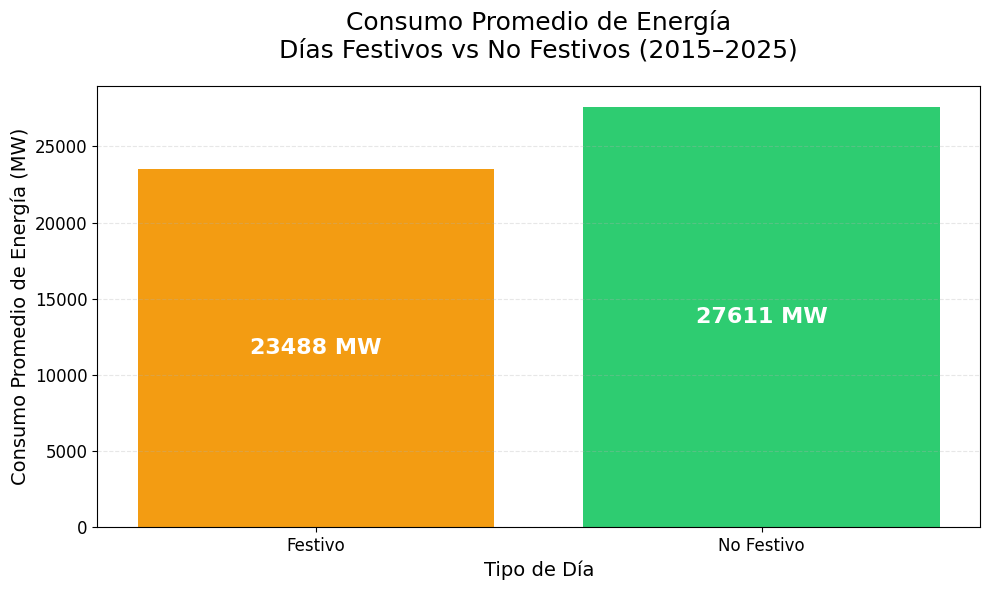

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import holidays

data['datetime'] = pd.to_datetime(data['datetime'])
data.set_index('datetime', inplace=True)

data['fecha'] = data.index.normalize()

festivos_es = holidays.Spain(years=range(2015, 2026))
festivos = pd.to_datetime(list(festivos_es.keys()))

data['tipo_dia'] = data['fecha'].apply(lambda x: 'Festivo' if x in festivos else 'No Festivo')

df_tipo_dia = data.groupby('tipo_dia')['value'].mean()

colores = {'Festivo': '#F39C12', 'No Festivo': '#2ECC71'}

plt.figure(figsize=(10, 6))
bars = plt.bar(df_tipo_dia.index, df_tipo_dia.values, color=[colores[tipo] for tipo in df_tipo_dia.index])

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval / 2,
             f'{yval:.0f} MW',
             ha='center', va='center',
             fontsize=16, color='white', fontweight='bold')


plt.title('Consumo Promedio de Energ√≠a\nD√≠as Festivos vs No Festivos (2015‚Äì2025)', fontsize=18, pad=20)
plt.xlabel('Tipo de D√≠a', fontsize=14)
plt.ylabel('Consumo Promedio de Energ√≠a (MW)', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()


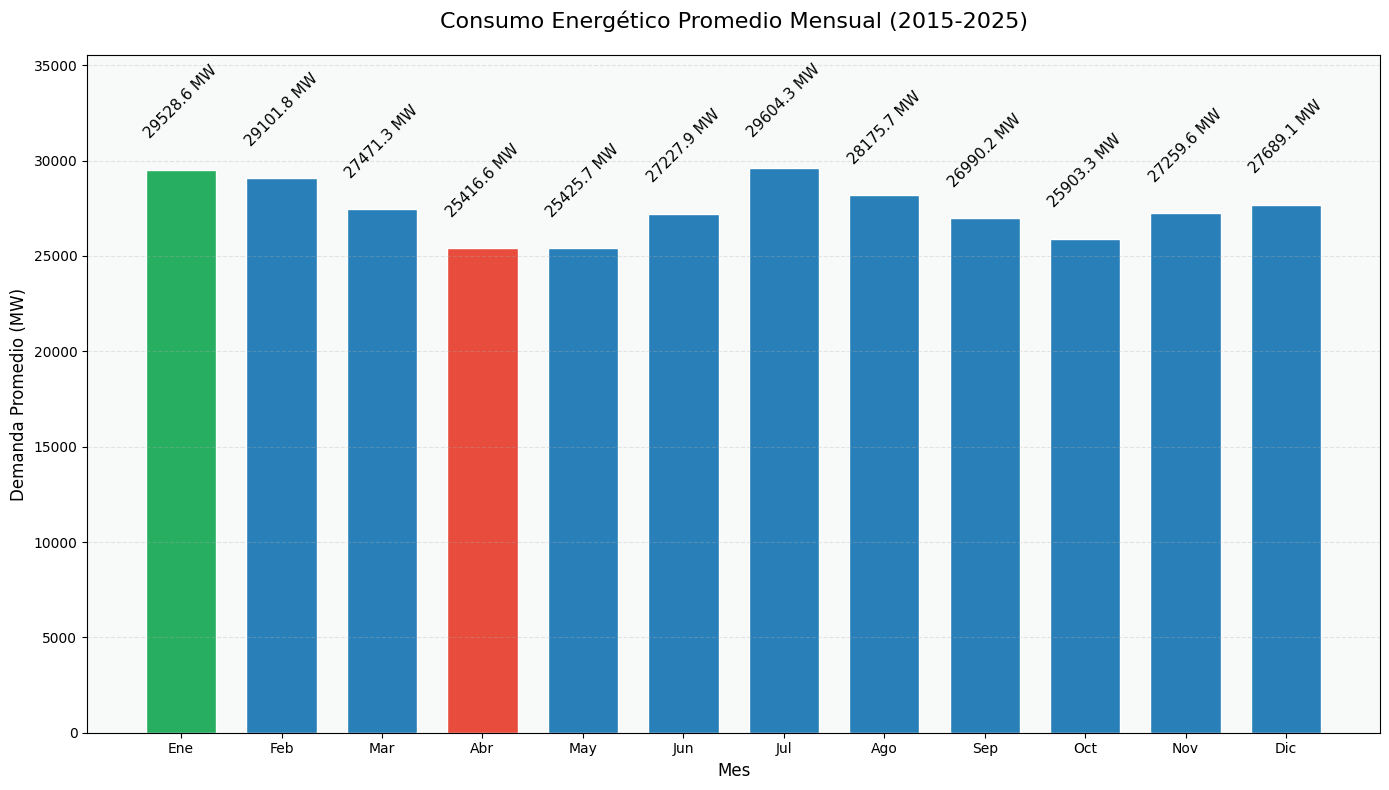

In [ ]:


data['datetime'] = pd.to_datetime(data['datetime'])

data.set_index('datetime', inplace=True)

data['mes'] = data.index.month
consumo_mensual = data.groupby('mes')['value'].mean().reset_index()

meses = ['Ene','Feb','Mar','Abr','May','Jun','Jul','Ago','Sep','Oct','Nov','Dic']
consumo_mensual['nombre_mes'] = consumo_mensual['mes'].map(lambda x: meses[x-1])

plt.figure(figsize=(14,8))
colors = ['#E74C3C' if m == 4 else '#27AE60' if m == 1 else '#2980B9'
          for m in consumo_mensual['mes']]

bars = plt.bar(
    consumo_mensual['nombre_mes'],
    consumo_mensual['value'],
    color=colors,
    width=0.7,
    edgecolor='white'
)

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2,
             yval + 0.05*max(consumo_mensual['value']),
             f'{yval:.1f} MW',
             ha='center',
             va='bottom',
             rotation=45,
             fontsize=11)

plt.title('Consumo Energ√©tico Promedio Mensual (2015-2025)', fontsize=16, pad=20)
plt.xlabel('Mes', fontsize=12)
plt.ylabel('Demanda Promedio (MW)', fontsize=12)
plt.ylim(0, max(consumo_mensual['value'])*1.2)
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.gca().set_facecolor('#F8F9F9')
plt.tight_layout()

plt.show()


In [ ]:
print("Informaci√≥n general del DataFrame:")
print(data.info())

Informaci√≥n general del DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 692585 entries, 0 to 692584
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   value     692585 non-null  int64         
 1   datetime  692585 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(1)
memory usage: 10.6 MB
None


In [ ]:
print("Primeras filas del DataFrame:")
print(data.head())

Primeras filas del DataFrame:
   value            datetime
0  25459 2014-12-31 23:00:00
1  25591 2014-12-31 23:10:00
2  25531 2014-12-31 23:20:00
3  25453 2014-12-31 23:30:00
4  25329 2014-12-31 23:40:00


In [ ]:
print("N√∫mero total de registros y variables:")
print(f"Filas: {data.shape[0]}, Columnas: {data.shape[1]}")

N√∫mero total de registros y variables:
Filas: 692585, Columnas: 2


In [ ]:
print("¬øLos datos est√°n ordenados cronol√≥gicamente?")
print(data.index.is_monotonic_increasing)

¬øLos datos est√°n ordenados cronol√≥gicamente?
True


In [ ]:
print("Tipo de datos en cada columna:")
print(data.dtypes)

Tipo de datos en cada columna:
value                int64
datetime    datetime64[ns]
dtype: object


In [ ]:
categorical_columns = data.select_dtypes(include=['object']).columns
print("\nüìå Variables categ√≥ricas detectadas:")
print(categorical_columns)


üìå Variables categ√≥ricas detectadas:
Index([], dtype='object')


In [ ]:
print("Valores nulos:")
print(data.isnull().sum())

Valores nulos:
datetime    0
value       0
dtype: int64


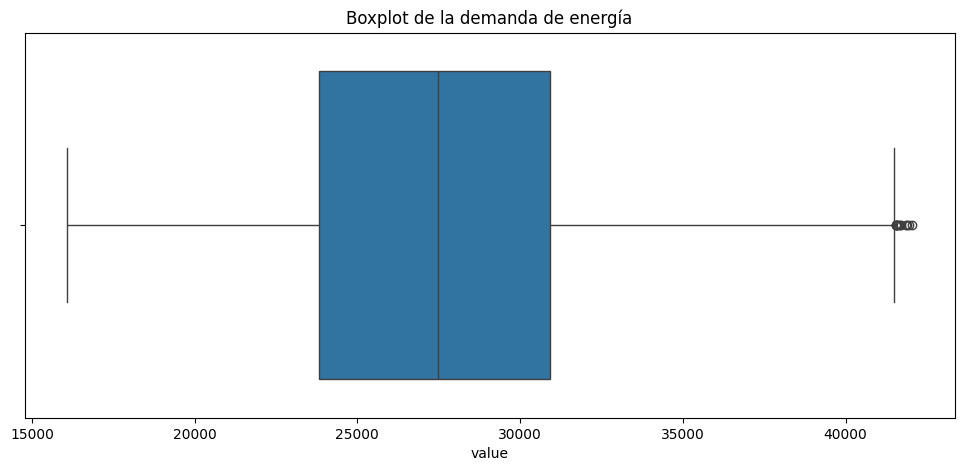

In [ ]:
# Usar boxplot para detectar valores an√≥malos
plt.figure(figsize=(12,5))
sns.boxplot(x=data['value'])
plt.title("Boxplot de la demanda de energ√≠a")
plt.show()

In [ ]:
# Detecci√≥n de outliers con el m√©todo IQR
Q1 = data['value'].quantile(0.25)
Q3 = data['value'].quantile(0.75)
IQR = Q3 - Q1

In [ ]:
outliers = data[(data['value'] < (Q1 - 1.5 * IQR)) | (df['value'] > (Q3 + 1.5 * IQR))]
print("\n Cantidad de valores at√≠picos detectados:", len(outliers))


 Cantidad de valores at√≠picos detectados: 12


In [ ]:
print("\nüìå Valores at√≠picos detectados:")
print(outliers)
print(outliers.min())
print(outliers.max())


üìå Valores at√≠picos detectados:
                        datetime  value
316725 2021-01-08 10:30:00+00:00  41550
316727 2021-01-08 10:50:00+00:00  41551
316732 2021-01-08 11:40:00+00:00  41588
316734 2021-01-08 12:00:00+00:00  41552
316735 2021-01-08 12:10:00+00:00  41885
316736 2021-01-08 12:20:00+00:00  42052
316737 2021-01-08 12:30:00+00:00  41960
316738 2021-01-08 12:40:00+00:00  41867
316739 2021-01-08 12:50:00+00:00  41657
317354 2021-01-12 19:20:00+00:00  41584
317356 2021-01-12 19:40:00+00:00  41699
317357 2021-01-12 19:50:00+00:00  41687
datetime    2021-01-08 10:30:00+00:00
value                           41550
dtype: object
datetime    2021-01-12 19:50:00+00:00
value                           42052
dtype: object


Valores At√≠picos, 24 de casi medio mill√≥n de registros. Rango [43650 - 44153]

*   Elemento de lista

*   Elemento de lista
*   Elemento de lista


*   Elemento de lista



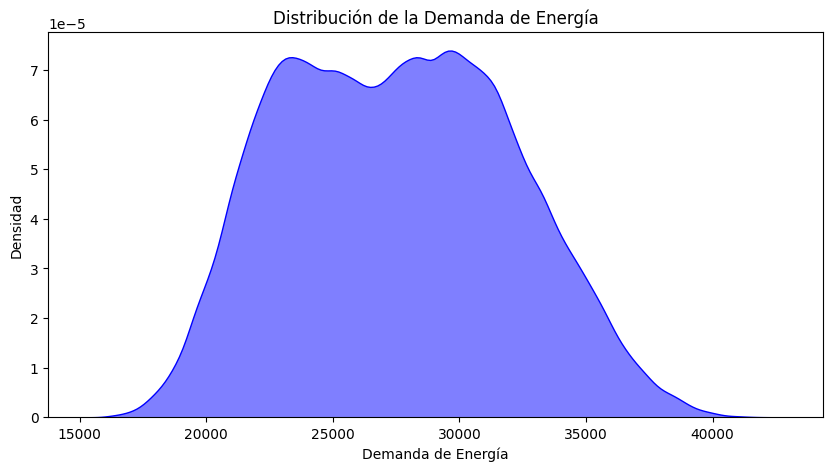

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Graficar la densidad de la demanda de energ√≠a
plt.figure(figsize=(10, 5))
sns.kdeplot(data['value'], fill=True, color="blue", alpha=0.5)
plt.title("Distribuci√≥n de la Demanda de Energ√≠a")
plt.xlabel("Demanda de Energ√≠a")
plt.ylabel("Densidad")
plt.show()

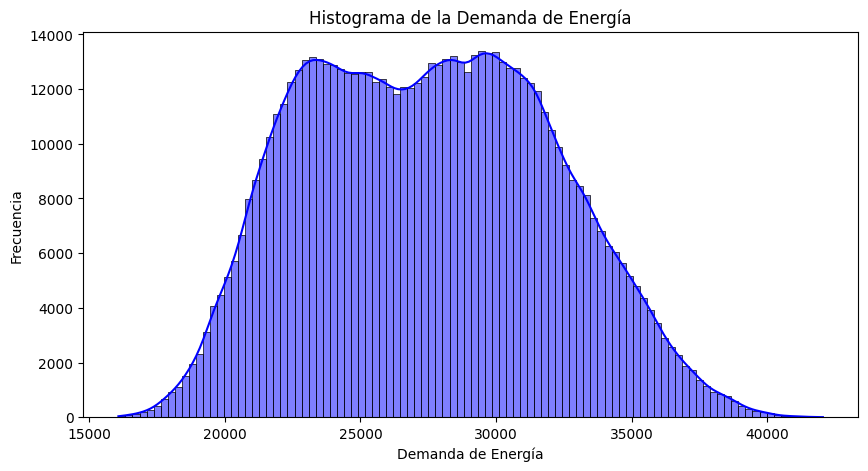

In [ ]:
plt.figure(figsize=(10, 5))
sns.histplot(data['value'], bins=100, kde=True, color="blue")
plt.title("Histograma de la Demanda de Energ√≠a")
plt.xlabel("Demanda de Energ√≠a")
plt.ylabel("Frecuencia")
plt.show()


**An√°lisis de Patrones y Estacionalidad**


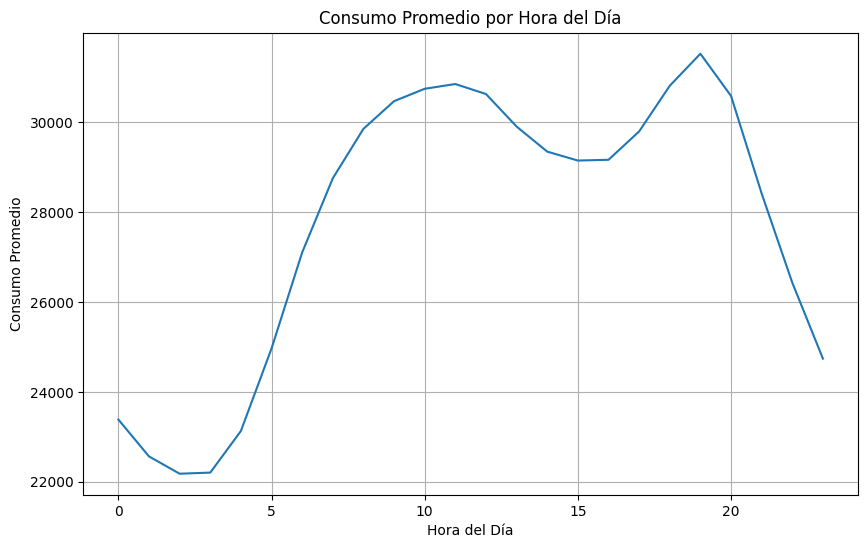

In [ ]:
data['datetime'] = data['datetime'].astype(str)
data['datetime'] = data['datetime'].str.split('+').str[0]
data['datetime'] = pd.to_datetime(data['datetime'])

data.set_index('datetime', inplace=True)

df_hourly = data['value'].resample('H').mean()
df_hourly_by_hour = df_hourly.groupby(df_hourly.index.hour).mean()

plt.figure(figsize=(10, 6))
df_hourly_by_hour.plot()
plt.title('Consumo Promedio por Hora del D√≠a')
plt.xlabel('Hora del D√≠a')
plt.ylabel('Consumo Promedio')
plt.grid(True)
plt.show()

<ipython-input-34-52baed056a9f>:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  data['value'].resample('M').mean().plot()


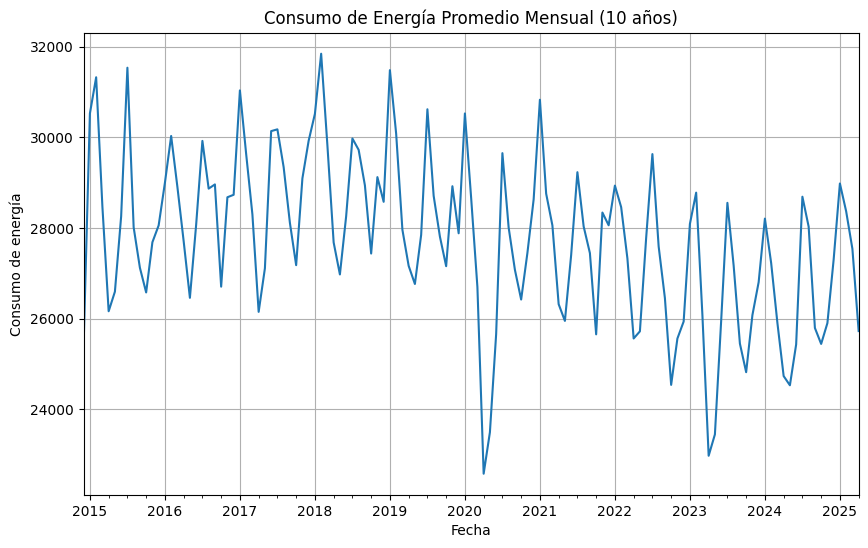

In [ ]:


plt.figure(figsize=(10, 6))
data['value'].resample('M').mean().plot()
plt.title('Consumo de Energ√≠a Promedio Mensual (10 a√±os)')
plt.xlabel('Fecha')
plt.ylabel('Consumo de energ√≠a')
plt.grid(True)
plt.show()

In [ ]:

df_daily = data['value'].resample('D').mean().to_frame()
df_daily['weekday'] = df_daily.index.weekday

weekly_pattern = df_daily.groupby('weekday')['value'].mean()
values = weekly_pattern.values

weekday_names = ['Lunes', 'Martes', 'Mi√©rcoles', 'Jueves', 'Viernes', 'S√°bado', 'Domingo']

offset = 0.03 * max(values)


text_pos_options = []
for i, value in enumerate(values):
    if i == 0:
        delta = values[i+1] - value
    elif i == len(values) - 1:
        delta = value - values[i-1]
    else:
        delta = (values[i+1] - values[i-1]) / 2

    if delta <= 0:
        text_pos_options.append('bottom center')
    else:
        text_pos_options.append('top center')

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=weekday_names,
    y=values,
    mode='lines+markers+text',
    text=[f'{v:.1f}' for v in values],
    textposition=text_pos_options,
    textfont=dict(size=18, color='black', family='Arial Black'),
    line=dict(color='#1f77b4', width=3),
    marker=dict(size=10)
))

fig.update_layout(
    xaxis_title='D√≠a de la Semana',
    yaxis_title='Consumo Promedio (kWh)',
    xaxis=dict(
        tickmode='array',
        tickvals=weekday_names,
        ticktext=weekday_names,
        tickfont=dict(size=24, family='Arial')
    ),
    yaxis=dict(
        showgrid=True,
        gridcolor='LightGray',
        zeroline=False,
        tickfont=dict(size=16, family='Arial')
    ),
    plot_bgcolor='white',
    margin=dict(l=70, r=70, t=70, b=70),
    font=dict(size=16)
)

fig.show()


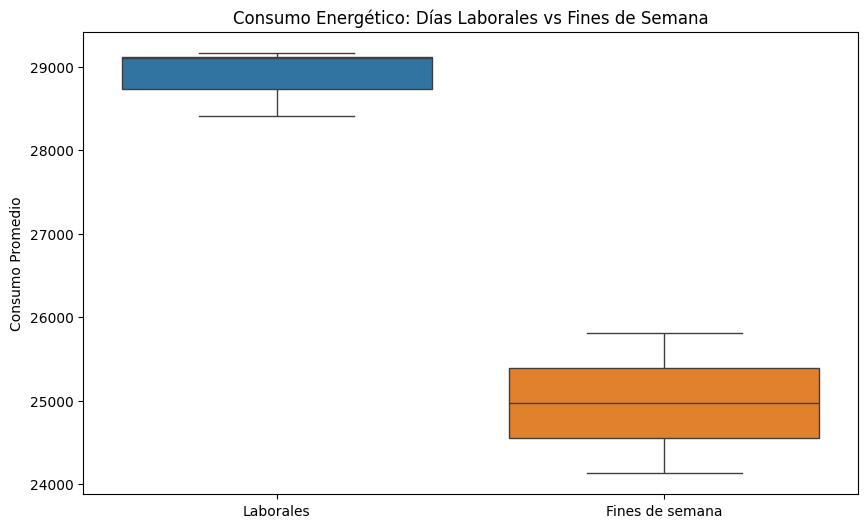

In [ ]:
df_daily = data['value'].resample('D').mean()

df_daily = df_daily.to_frame()
df_daily['weekday'] = df_daily.index.weekday

weekdays = df_daily[df_daily['weekday'] < 5].groupby('weekday')['value'].mean()
weekends = df_daily[df_daily['weekday'] >= 5].groupby('weekday')['value'].mean()

plt.figure(figsize=(10, 6))

data_to_plot = [weekdays.values, weekends.values]
ax = sns.boxplot(data=data_to_plot)

plt.xticks([0, 1], ['Laborales', 'Fines de semana'])

plt.title('Consumo Energ√©tico: D√≠as Laborales vs Fines de Semana')
plt.ylabel('Consumo Promedio')
plt.show()

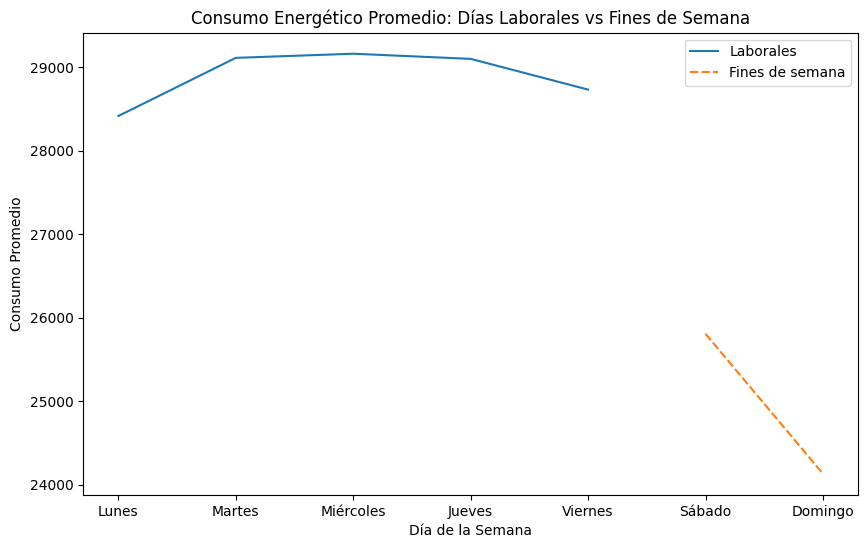

In [ ]:
df_lineplot = pd.DataFrame({
    'Laborales': weekdays,
    'Fines de semana': weekends
})

plt.figure(figsize=(10, 6))
sns.lineplot(data=df_lineplot)
plt.title('Consumo Energ√©tico Promedio: D√≠as Laborales vs Fines de Semana')
plt.xlabel('D√≠a de la Semana')
plt.ylabel('Consumo Promedio')
plt.xticks(range(7), ['Lunes', 'Martes', 'Mi√©rcoles', 'Jueves', 'Viernes', 'S√°bado', 'Domingo'])
plt.show()

<ipython-input-28-2df5e6b6743f>:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_monthly = data['value'].resample('M').mean()


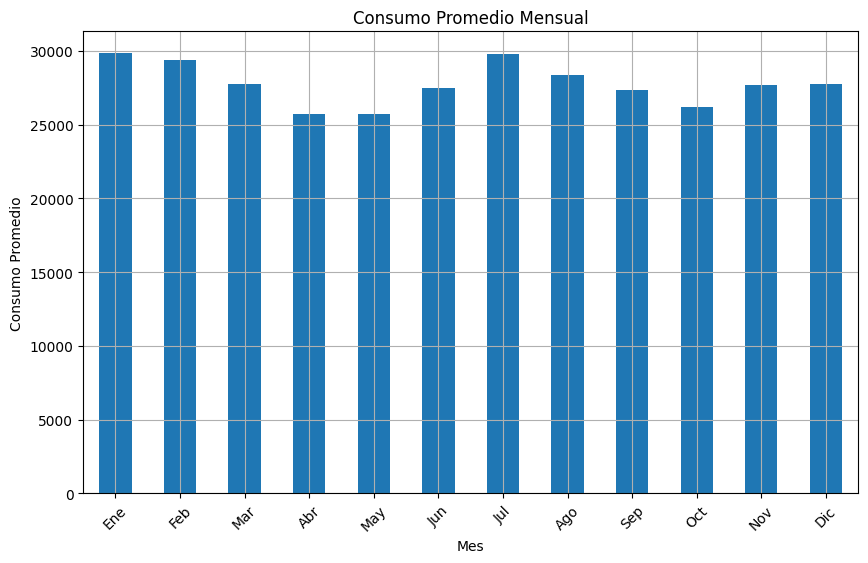

In [ ]:
df_monthly = data['value'].resample('M').mean()

df_monthly = df_monthly.to_frame()
df_monthly['month'] = df_monthly.index.month

df_monthly_mean = df_monthly.groupby('month')['value'].mean()


plt.figure(figsize=(10, 6))
df_monthly_mean.plot(kind='bar')
plt.title('Consumo Promedio Mensual')
plt.xlabel('Mes')
plt.ylabel('Consumo Promedio')
plt.xticks(range(12), ['Ene', 'Feb', 'Mar', 'Abr', 'May', 'Jun', 'Jul', 'Ago', 'Sep', 'Oct', 'Nov', 'Dic'], rotation=45)
plt.grid(True)
plt.show()

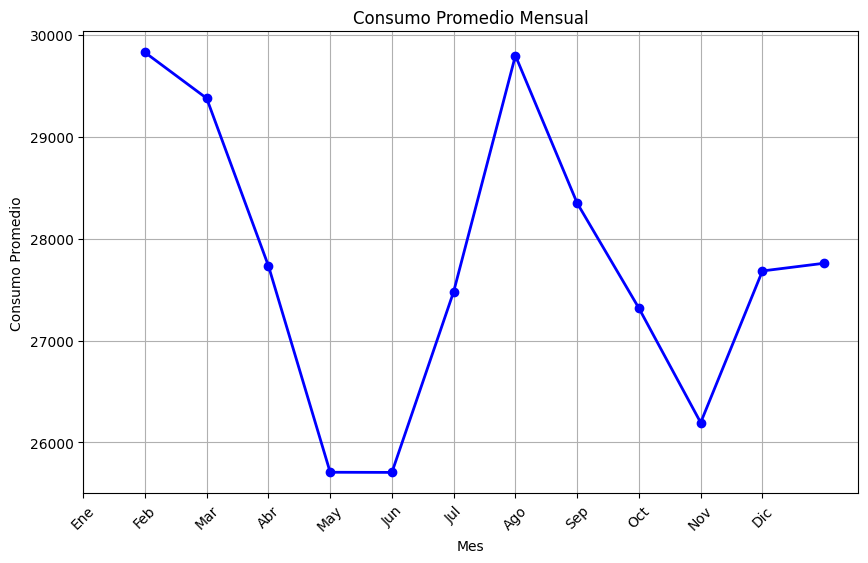

In [ ]:
plt.figure(figsize=(10, 6))
df_monthly_mean.plot(kind='line', marker='o', color='b', linewidth=2)
plt.title('Consumo Promedio Mensual')
plt.xlabel('Mes')
plt.ylabel('Consumo Promedio')
plt.xticks(range(12), ['Ene', 'Feb', 'Mar', 'Abr', 'May', 'Jun', 'Jul', 'Ago', 'Sep', 'Oct', 'Nov', 'Dic'], rotation=45)
plt.grid(True)
plt.show()


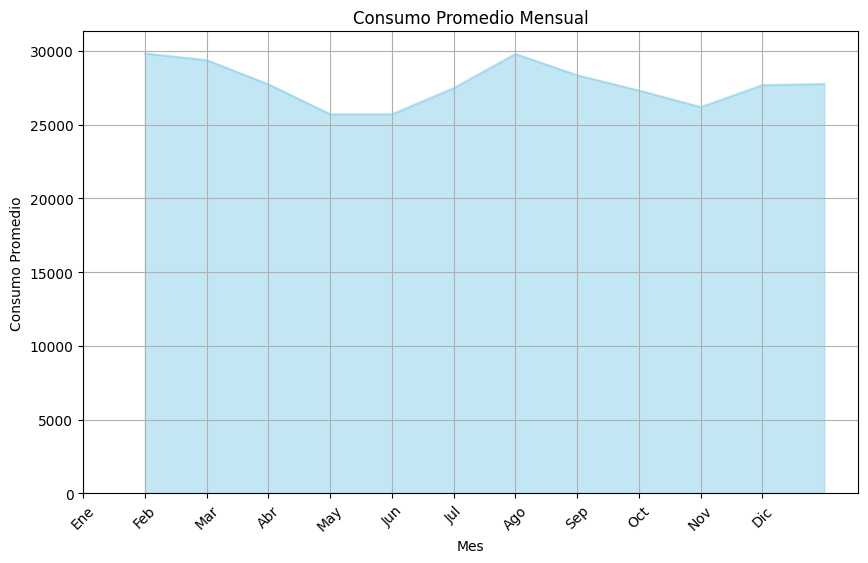

In [ ]:
plt.figure(figsize=(10, 6))
df_monthly_mean.plot(kind='area', color='skyblue', alpha=0.5)
plt.title('Consumo Promedio Mensual')
plt.xlabel('Mes')
plt.ylabel('Consumo Promedio')
plt.xticks(range(12), ['Ene', 'Feb', 'Mar', 'Abr', 'May', 'Jun', 'Jul', 'Ago', 'Sep', 'Oct', 'Nov', 'Dic'], rotation=45)
plt.grid(True)
plt.show()

<ipython-input-31-b7adf7ea6a69>:2: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  df_yearly = data['value'].resample('A').mean()


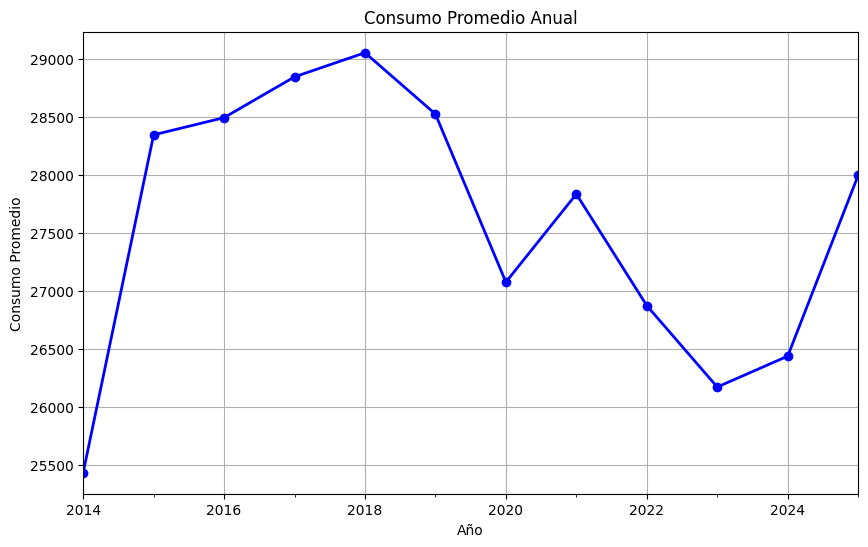

In [ ]:
df_yearly = data['value'].resample('A').mean()


plt.figure(figsize=(10, 6))
df_yearly.plot(kind='line', marker='o', color='b', linewidth=2)
plt.title('Consumo Promedio Anual')
plt.xlabel('A√±o')
plt.ylabel('Consumo Promedio')
plt.grid(True)
plt.show()


<ipython-input-32-412312c63558>:2: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  df_yearly = data['value'].resample('A').mean()


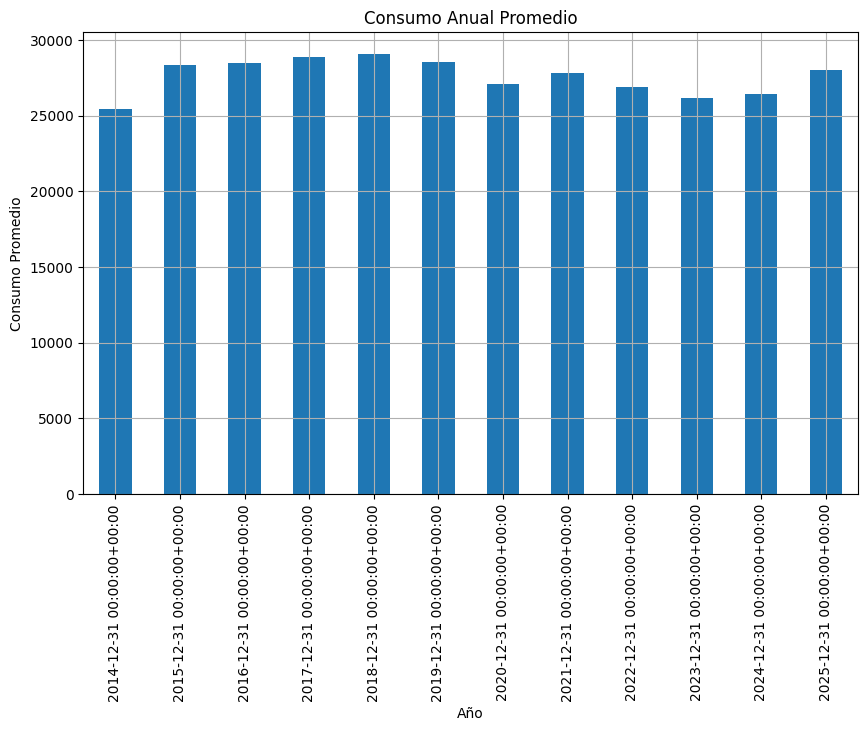

In [ ]:
df_yearly = data['value'].resample('A').mean()

plt.figure(figsize=(10, 6))
df_yearly.plot(kind='bar')
plt.title('Consumo Anual Promedio')
plt.xlabel('A√±o')
plt.ylabel('Consumo Promedio')
plt.grid(True)
plt.show()


In [ ]:
percentile_95 = data['value'].quantile(0.95)

picos = data[data['value'] > percentile_95]

print(picos)


                           value
datetime                        
2015-01-07 08:20:00+00:00  35272
2015-01-07 08:30:00+00:00  35332
2015-01-07 08:40:00+00:00  35784
2015-01-07 08:50:00+00:00  35905
2015-01-07 09:00:00+00:00  36208
...                          ...
2025-03-25 20:00:00+00:00  35397
2025-03-25 20:05:00+00:00  35348
2025-03-25 20:10:00+00:00  35249
2025-03-25 20:15:00+00:00  35219
2025-03-25 20:20:00+00:00  35137

[34620 rows x 1 columns]


**Descomposici√≥n de la Serie Temporal**

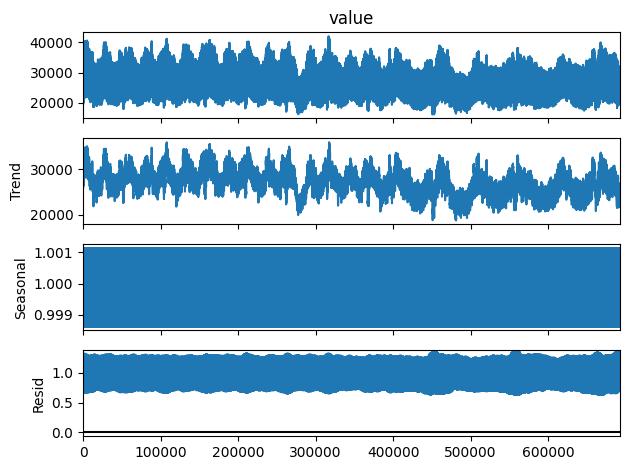

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(data['value'], model='multiplicative', period=365)

result.plot()
plt.show()


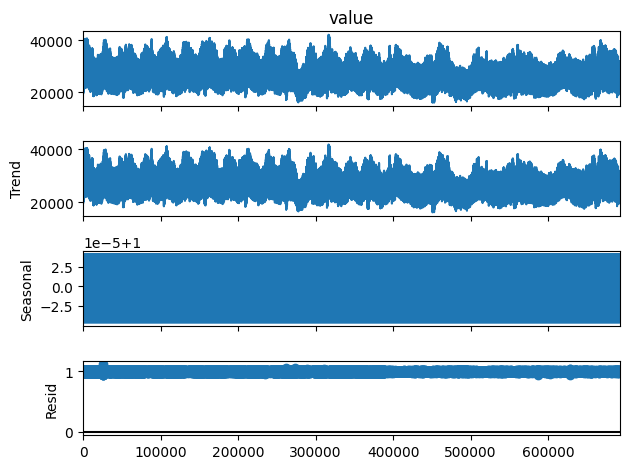

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(data['value'], model='multiplicative', period=7)

result.plot()
plt.show()

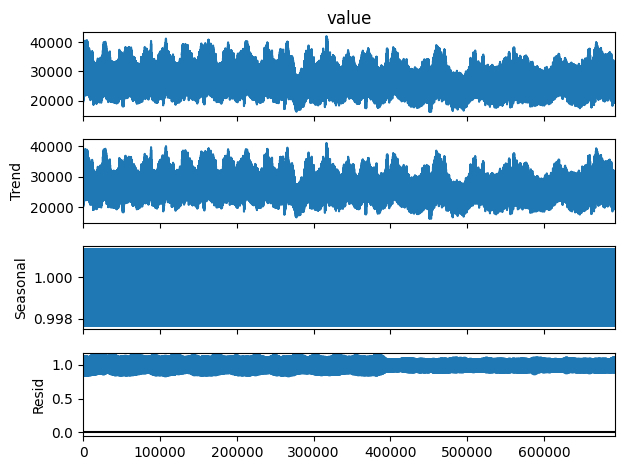

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(data['value'], model='multiplicative', period=30)

result.plot()
plt.show()

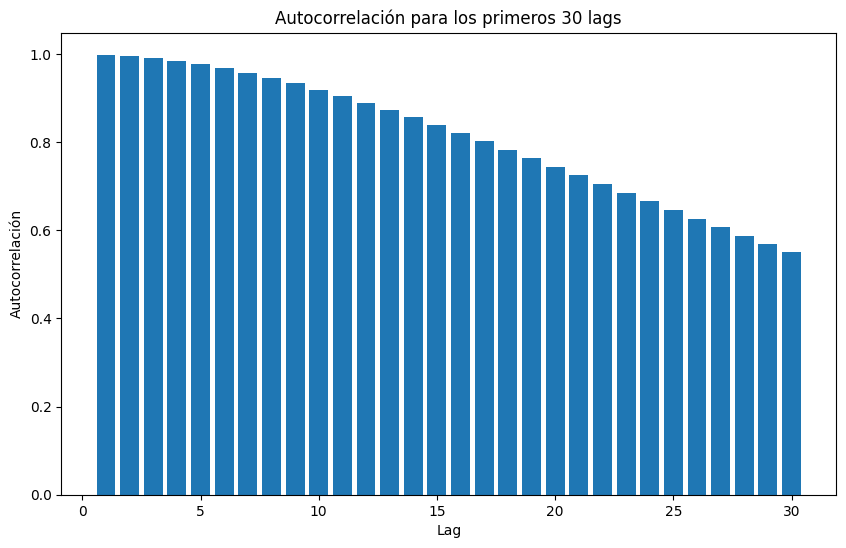

In [ ]:
import numpy as np

lags = 30
autocorr_values = [data['value'].autocorr(lag=i) for i in range(1, lags + 1)]

plt.figure(figsize=(10, 6))
plt.bar(range(1, lags + 1), autocorr_values)
plt.title('Autocorrelaci√≥n para los primeros 30 lags')
plt.xlabel('Lag')
plt.ylabel('Autocorrelaci√≥n')
plt.show()


<ipython-input-96-2cd850922ec2>:4: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  plot_acf(data['value'].resample('M').mean(), lags=30)  # Limitar a 30 lags


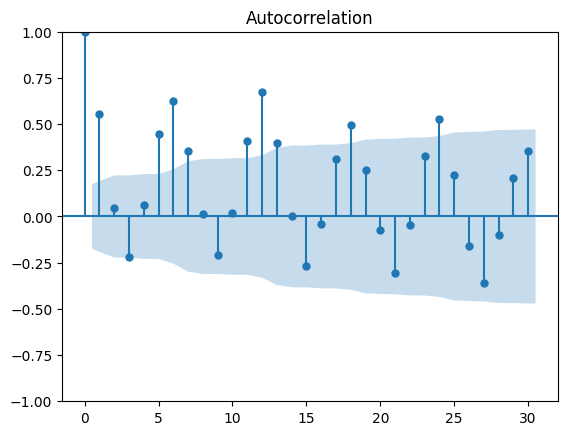

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(data['value'].resample('M').mean(), lags=30)
plt.show()


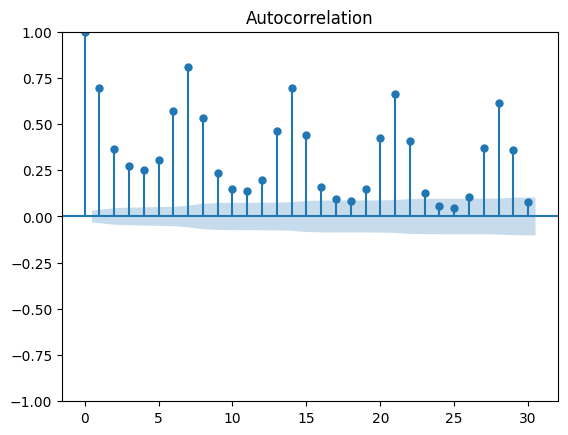

In [ ]:
plot_acf(data['value'].resample('D').mean(), lags=30)
plt.show()


In [ ]:
mape = (comparison['y'] - comparison['yhat']).abs().mean() / comparison['y'].mean() * 100
print(f'MAPE (Error porcentual absoluto medio): {mape:.2f}%')


MAPE (Error porcentual absoluto medio): 4.36%


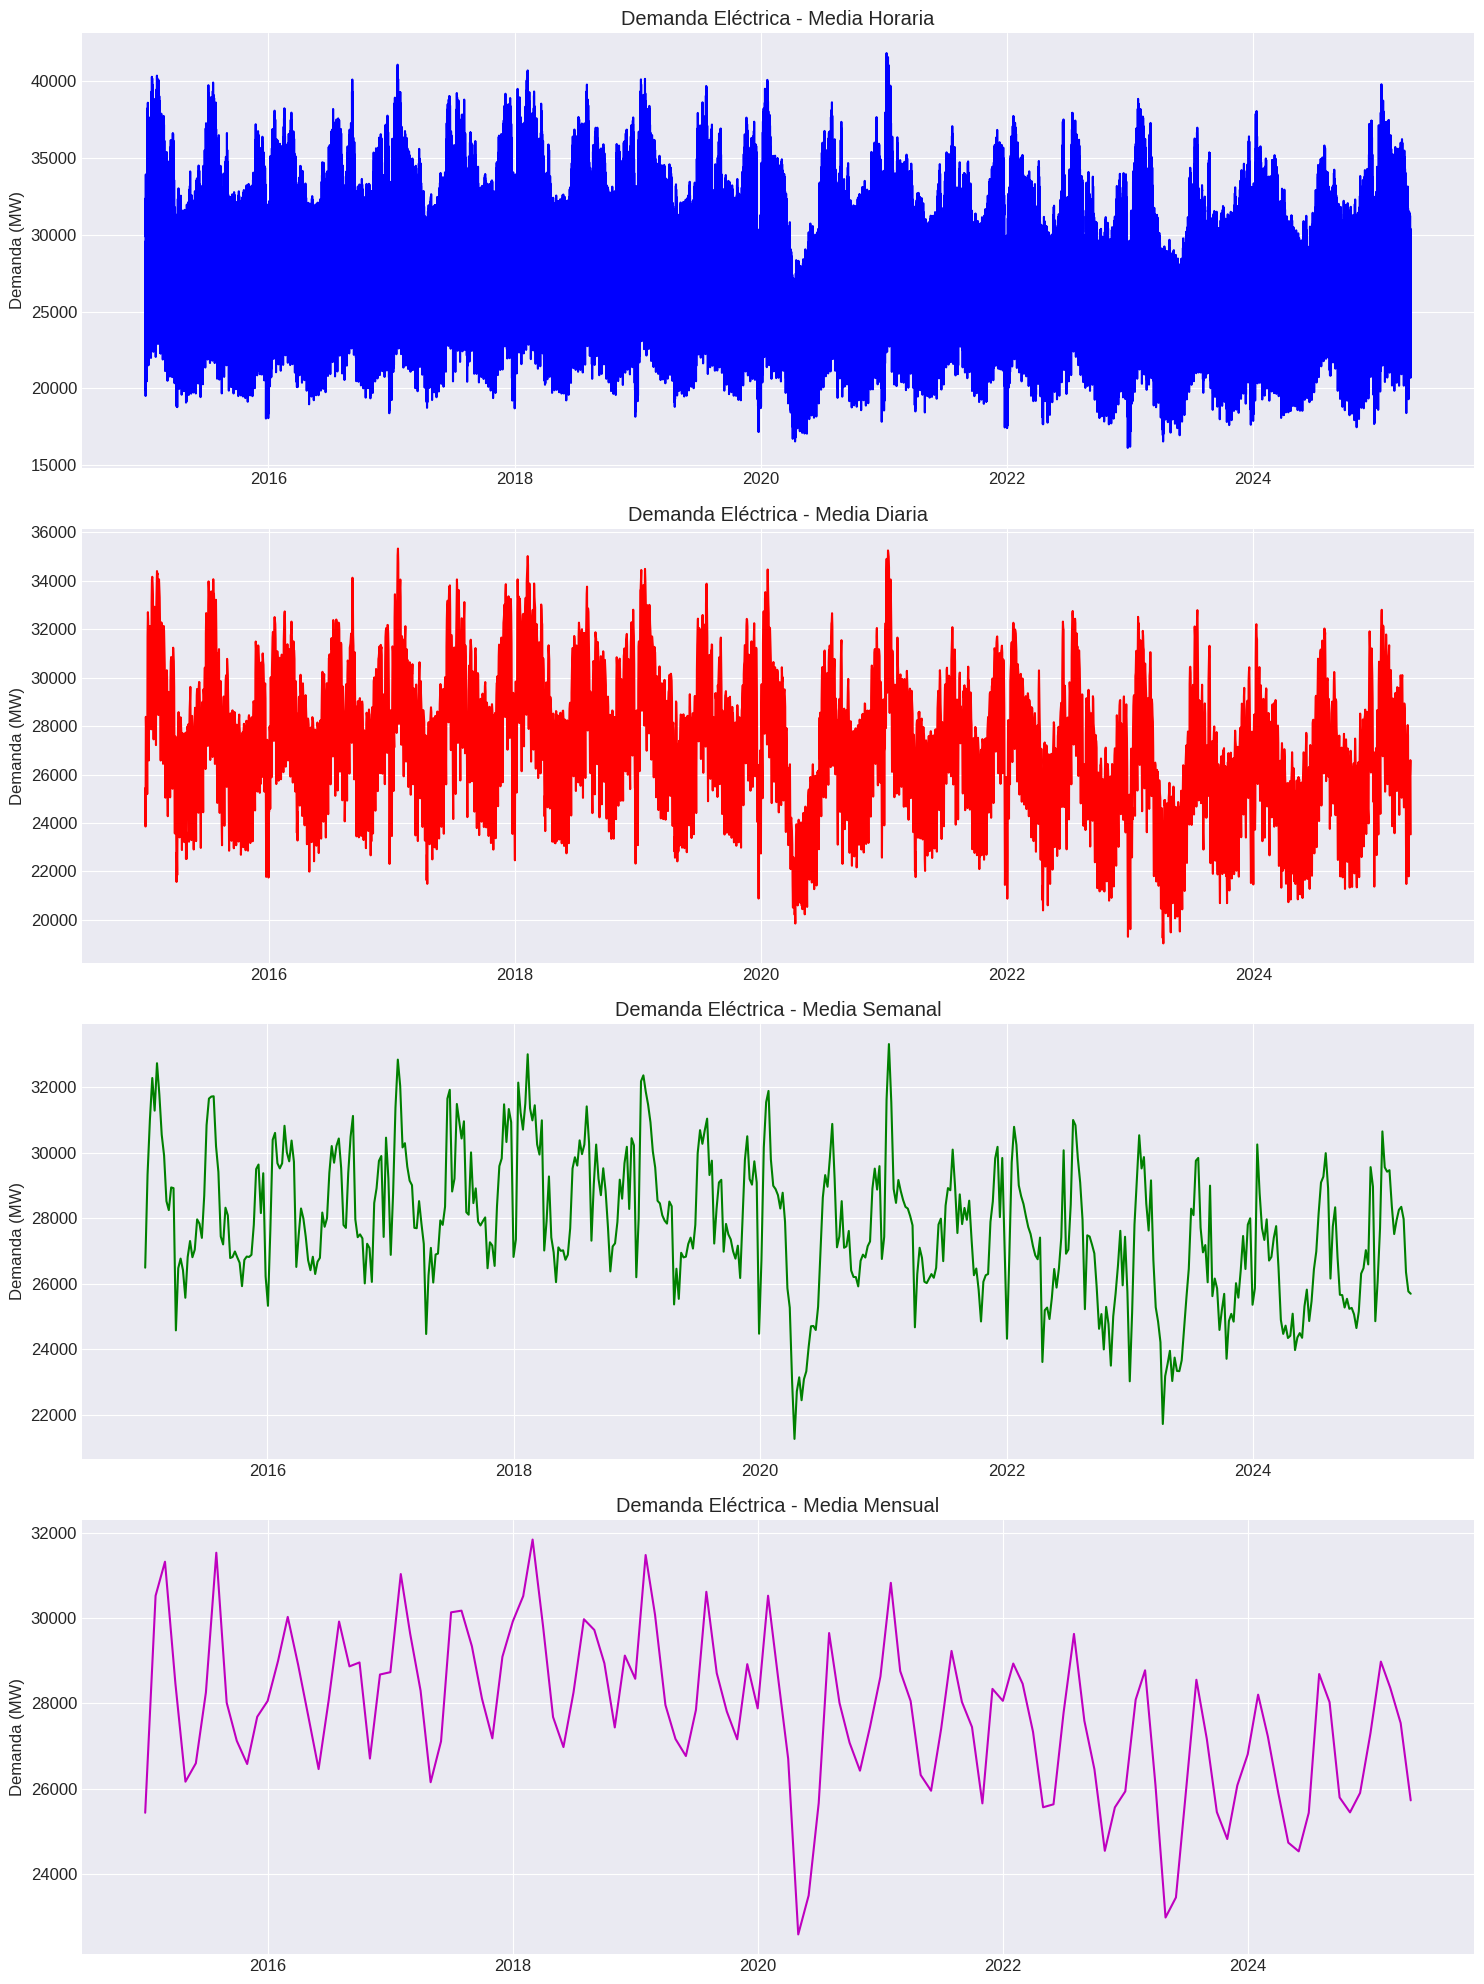

In [ ]:
df_hora = df.resample('H').mean()
df_dia = df.resample('D').mean()
df_semana = df.resample('W').mean()
df_mes = df.resample('M').mean()

fig, axes = plt.subplots(4, 1, figsize=(15, 20), sharex=False)

axes[0].plot(df_hora.index, df_hora['demanda_mw'], 'b-')
axes[0].set_title('Demanda El√©ctrica - Media Horaria')
axes[0].set_ylabel('Demanda (MW)')
axes[0].grid(True)

axes[1].plot(df_dia.index, df_dia['demanda_mw'], 'r-')
axes[1].set_title('Demanda El√©ctrica - Media Diaria')
axes[1].set_ylabel('Demanda (MW)')
axes[1].grid(True)

axes[2].plot(df_semana.index, df_semana['demanda_mw'], 'g-')
axes[2].set_title('Demanda El√©ctrica - Media Semanal')
axes[2].set_ylabel('Demanda (MW)')
axes[2].grid(True)

axes[3].plot(df_mes.index, df_mes['demanda_mw'], 'm-')
axes[3].set_title('Demanda El√©ctrica - Media Mensual')
axes[3].set_ylabel('Demanda (MW)')
axes[3].grid(True)

plt.tight_layout()
plt.show()


=== AN√ÅLISIS COMPLETO DE DEMANDA EL√âCTRICA ===

Archivo cargado correctamente: 692585 filas, 4 columnas
Datos originales: 692585 registros
Datos horarios: 90114 registros
Datos diarios: 3756 registros

Analizando patrones temporales...


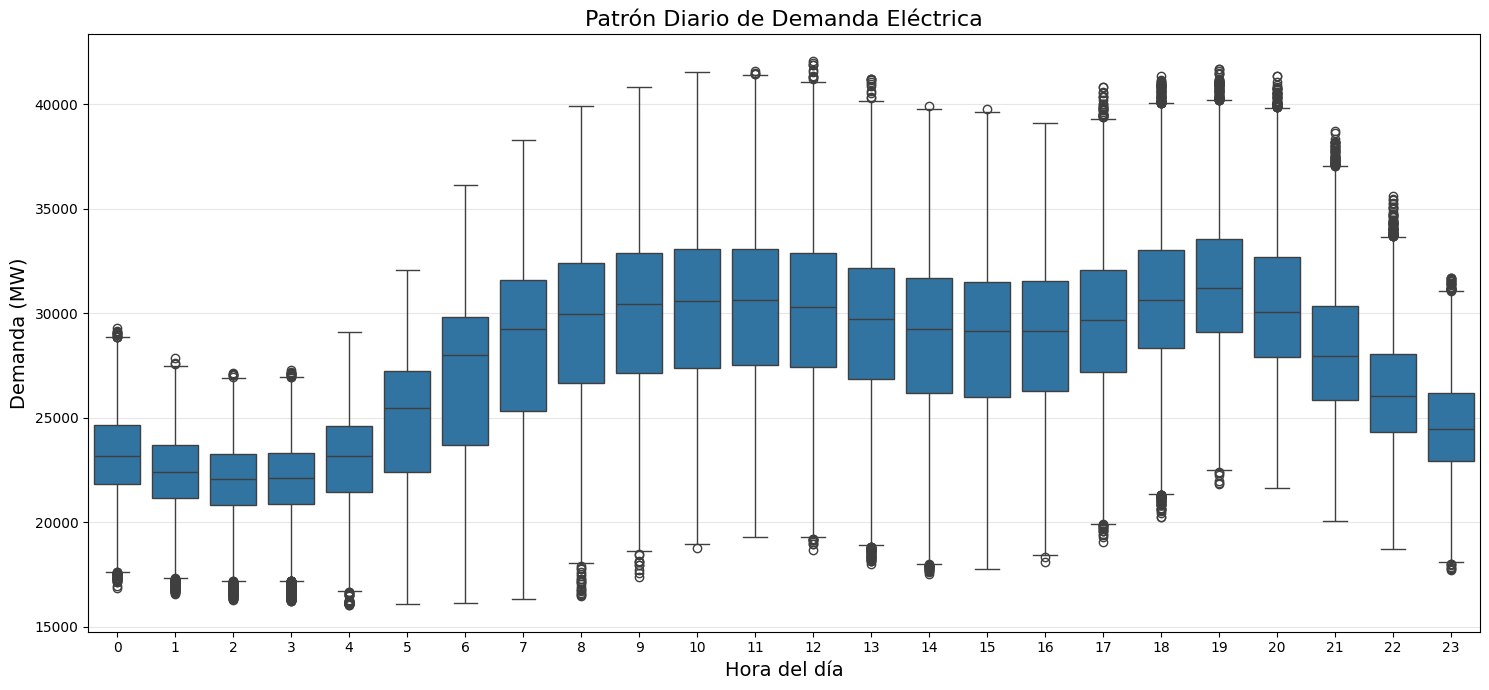

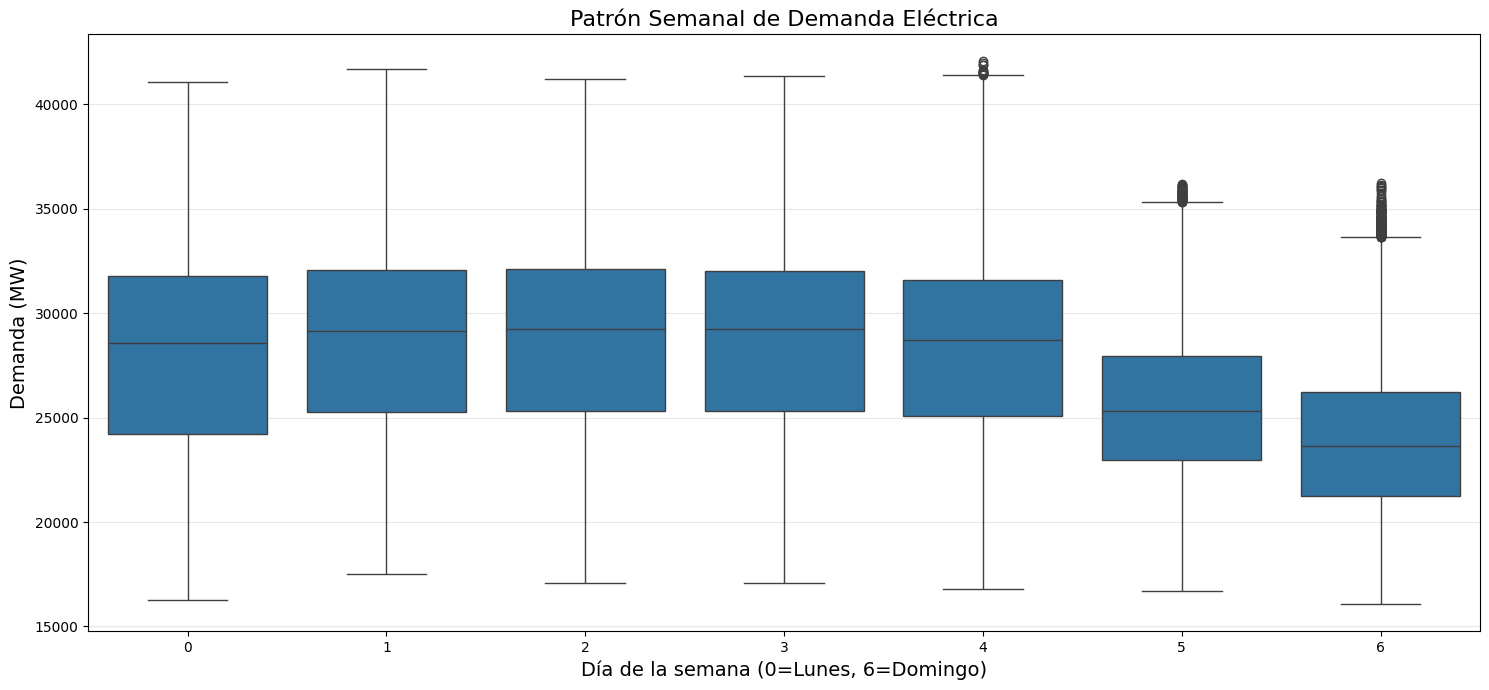

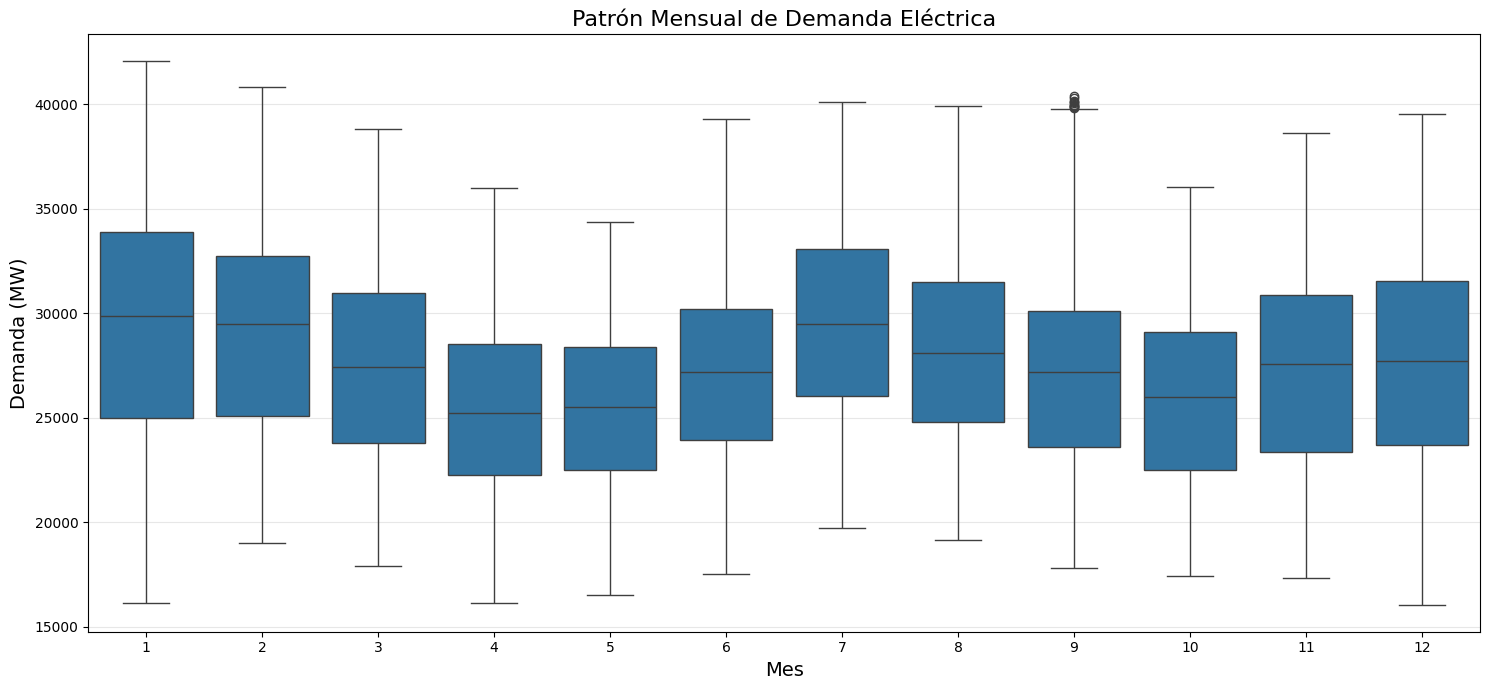

Realizando descomposici√≥n estacional diaria...


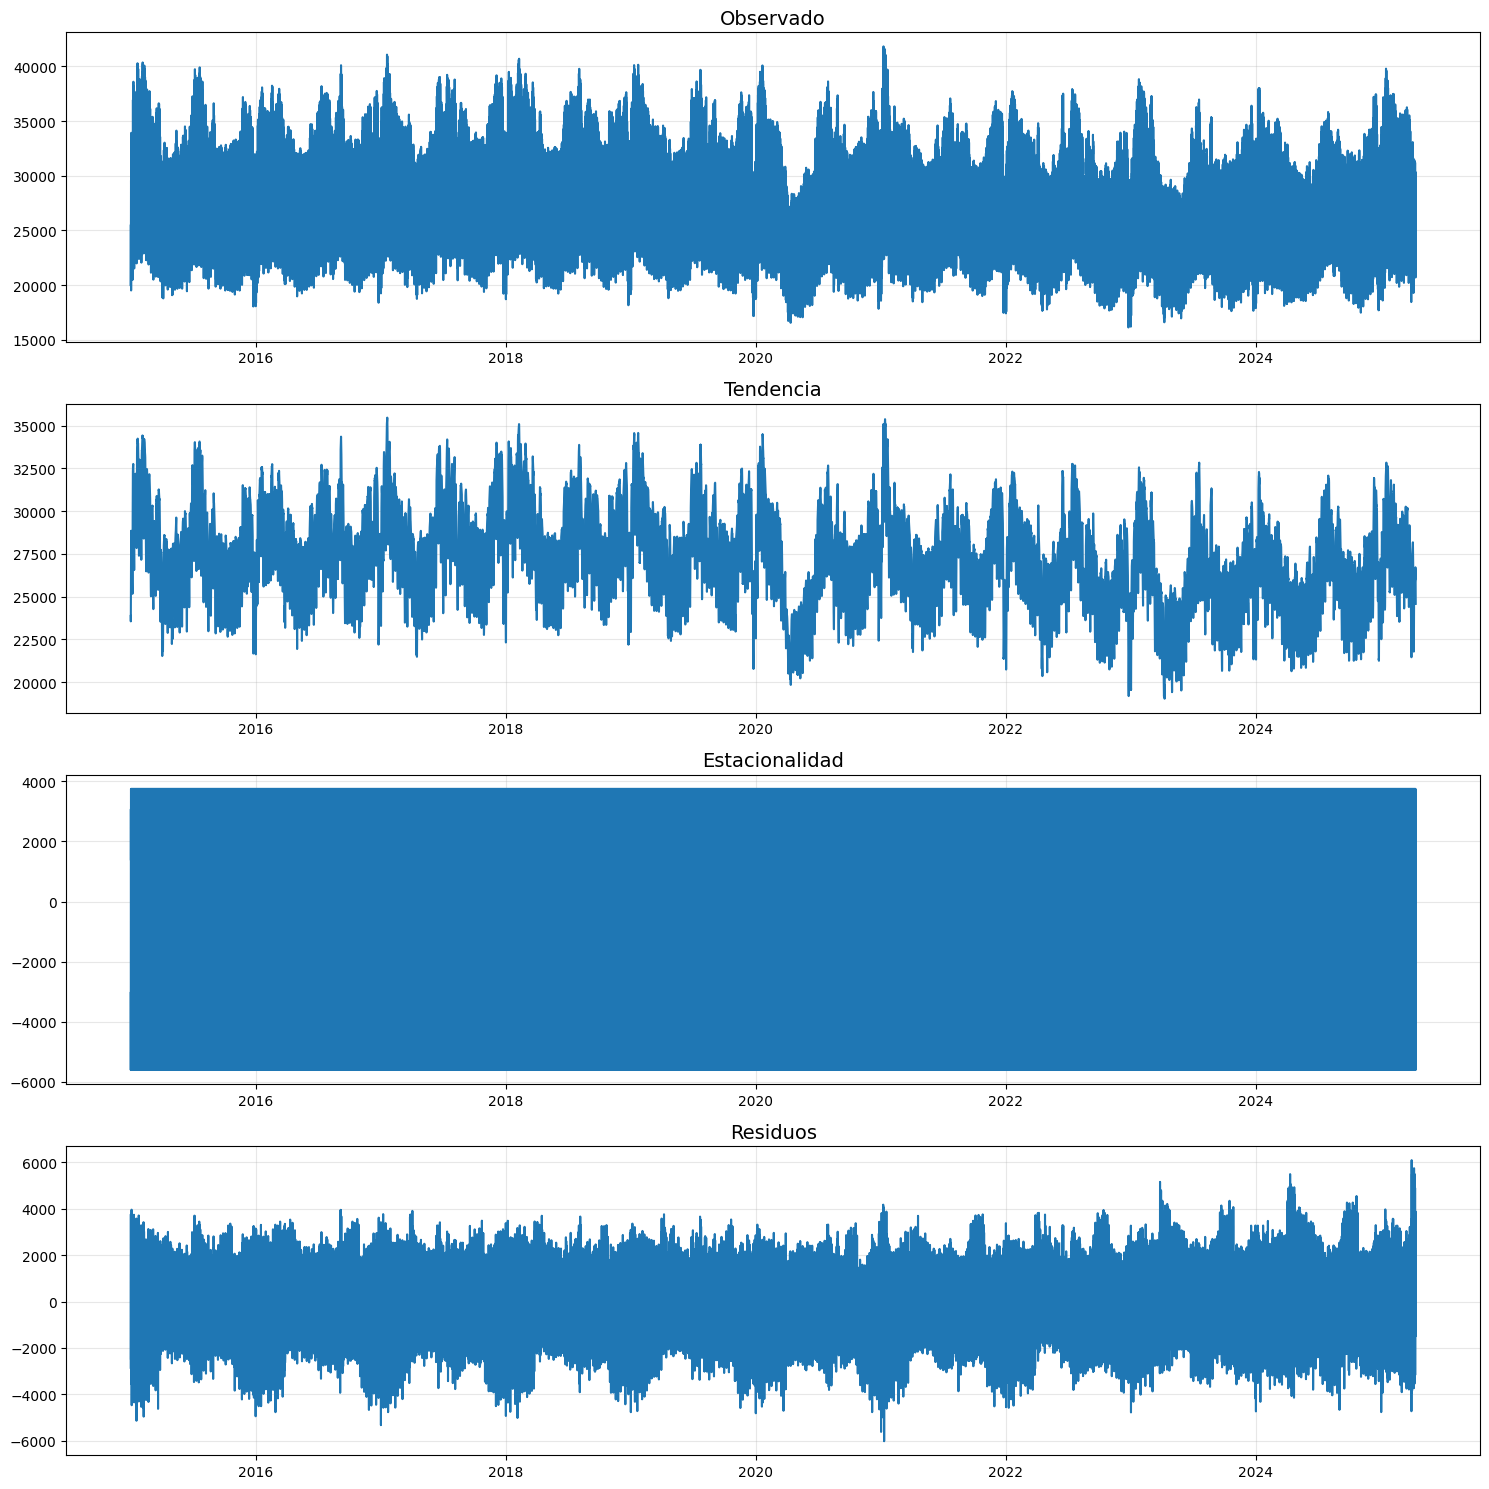


Realizando descomposici√≥n estacional semanal...
Usando muestra de 50000 registros para descomposici√≥n semanal


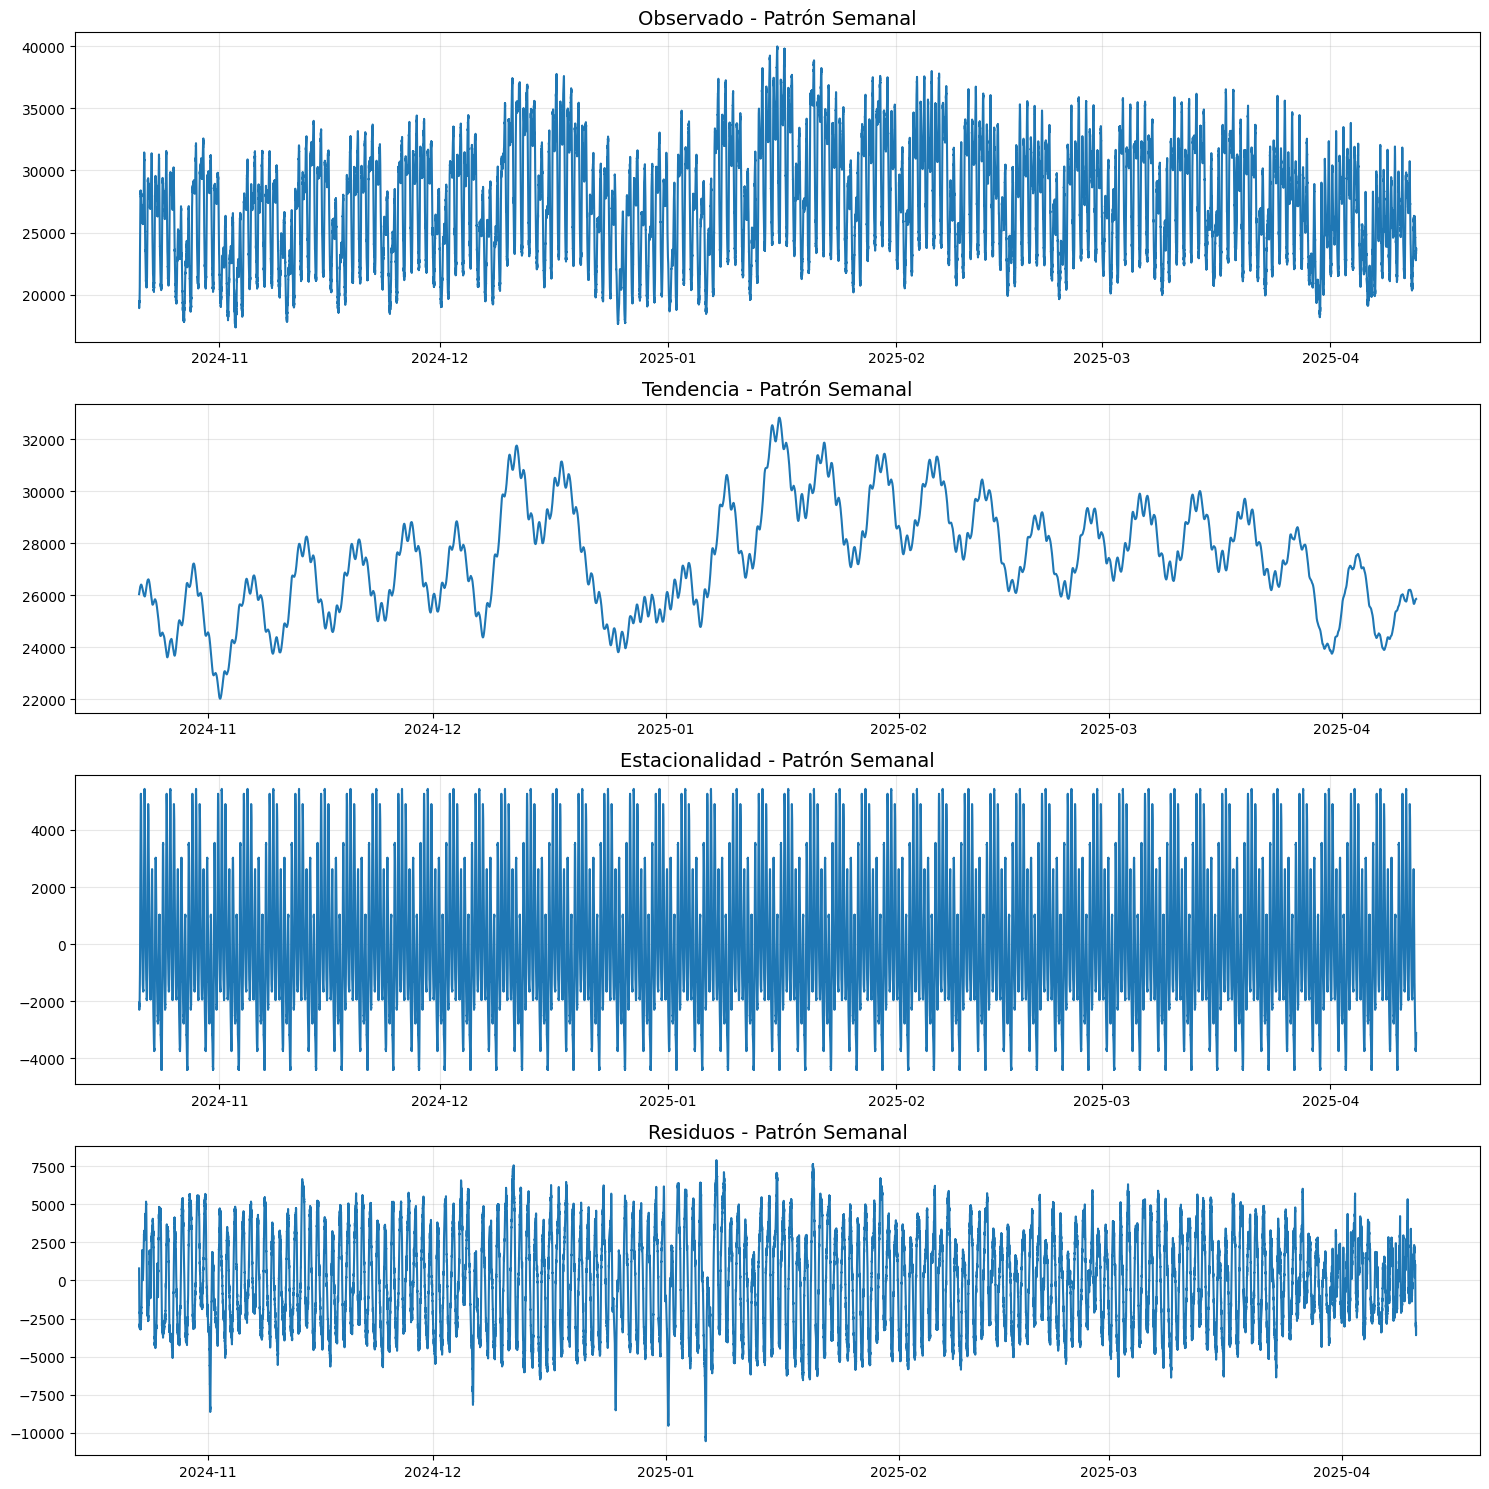


Analizando funciones de autocorrelaci√≥n...


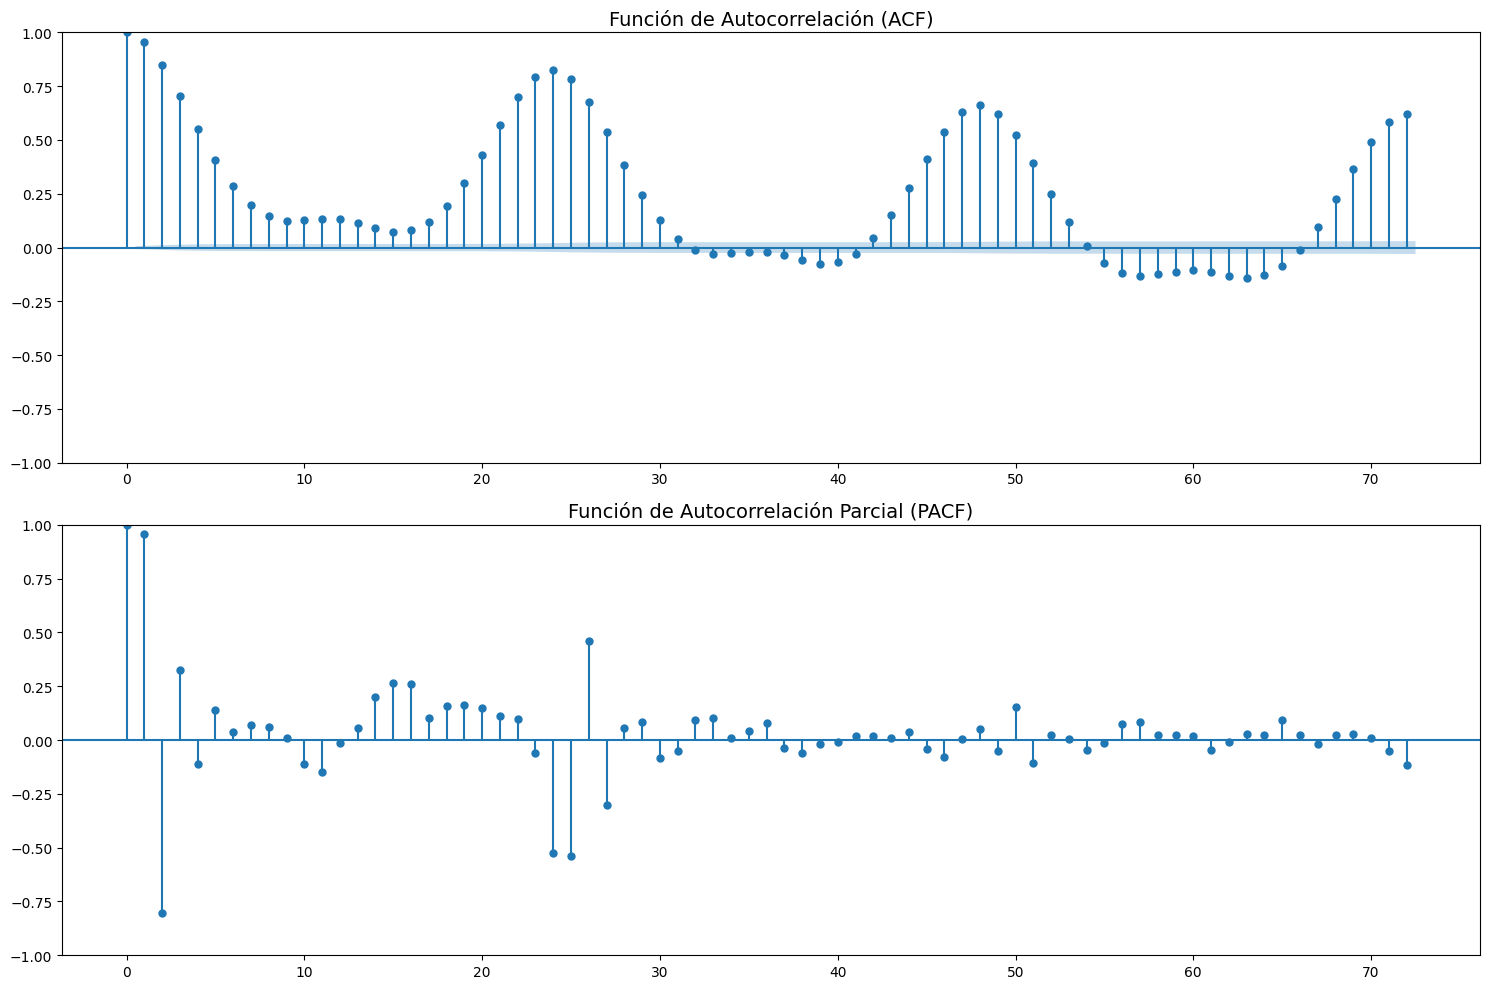


Realizando test de estacionariedad...


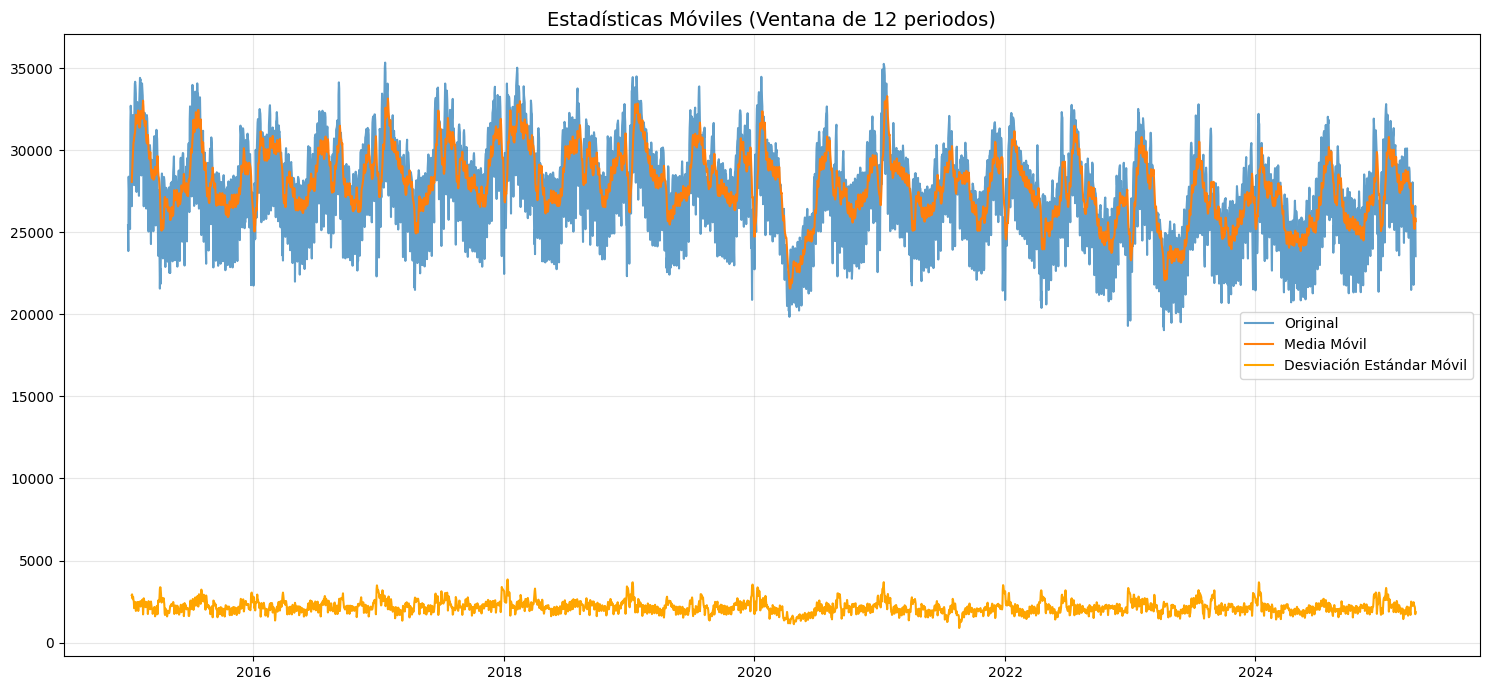


Calculando desviaci√≥n est√°ndar m√≥vil con agregaci√≥n D...


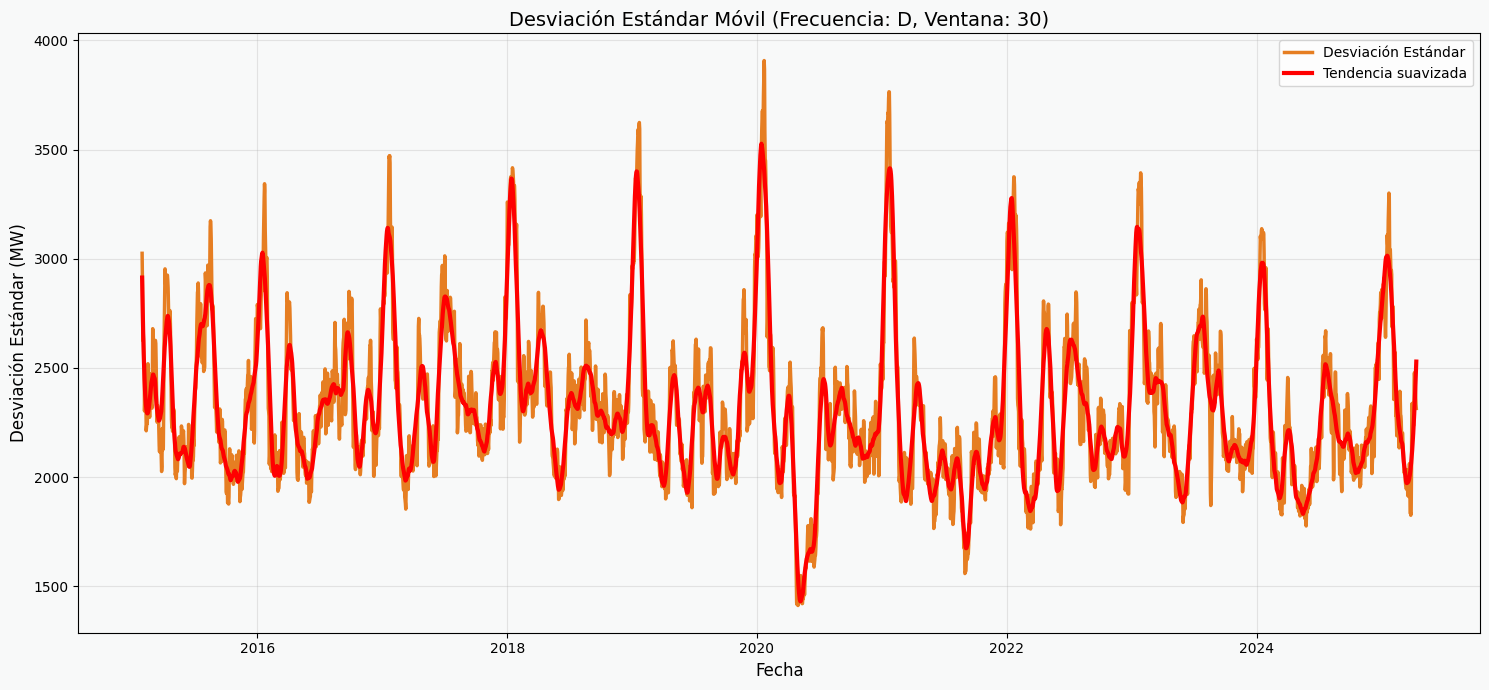


Calculando desviaci√≥n est√°ndar m√≥vil con agregaci√≥n W...


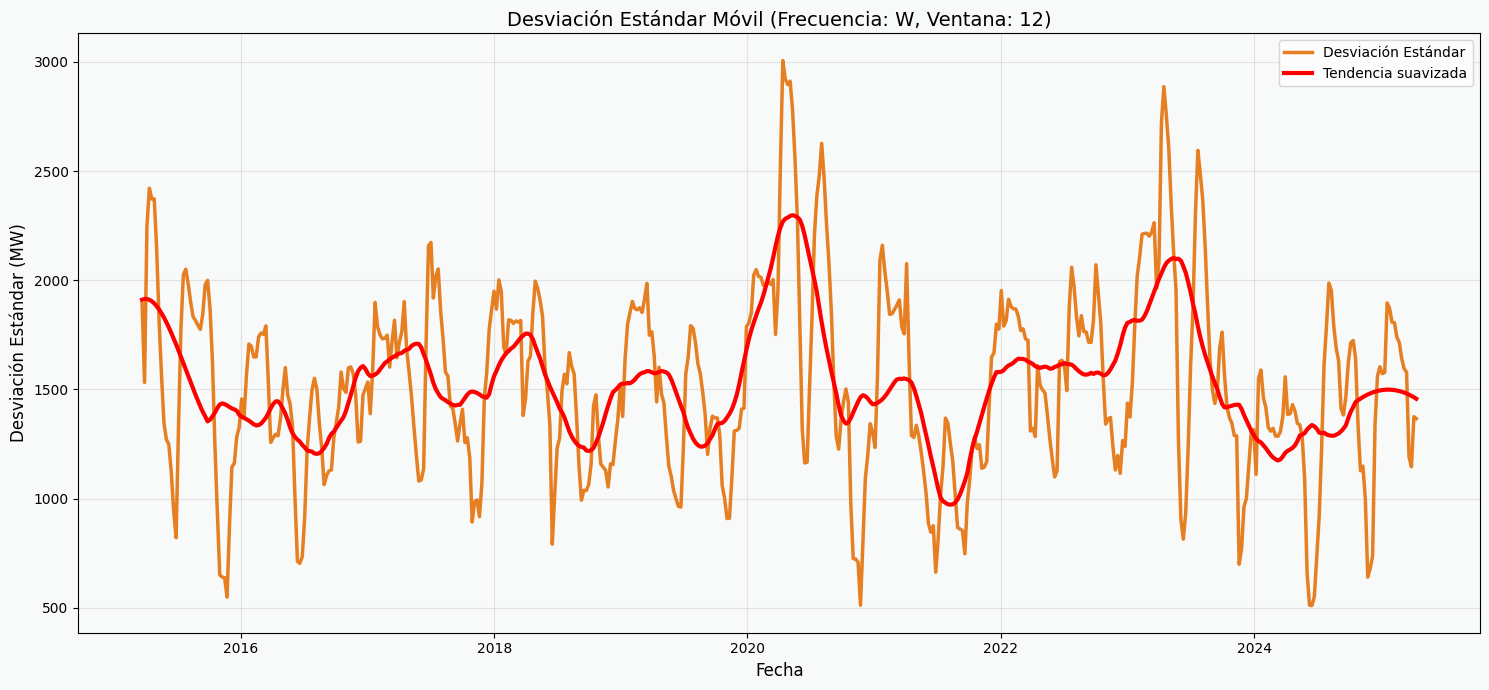


Calculando desviaci√≥n est√°ndar m√≥vil con agregaci√≥n M...


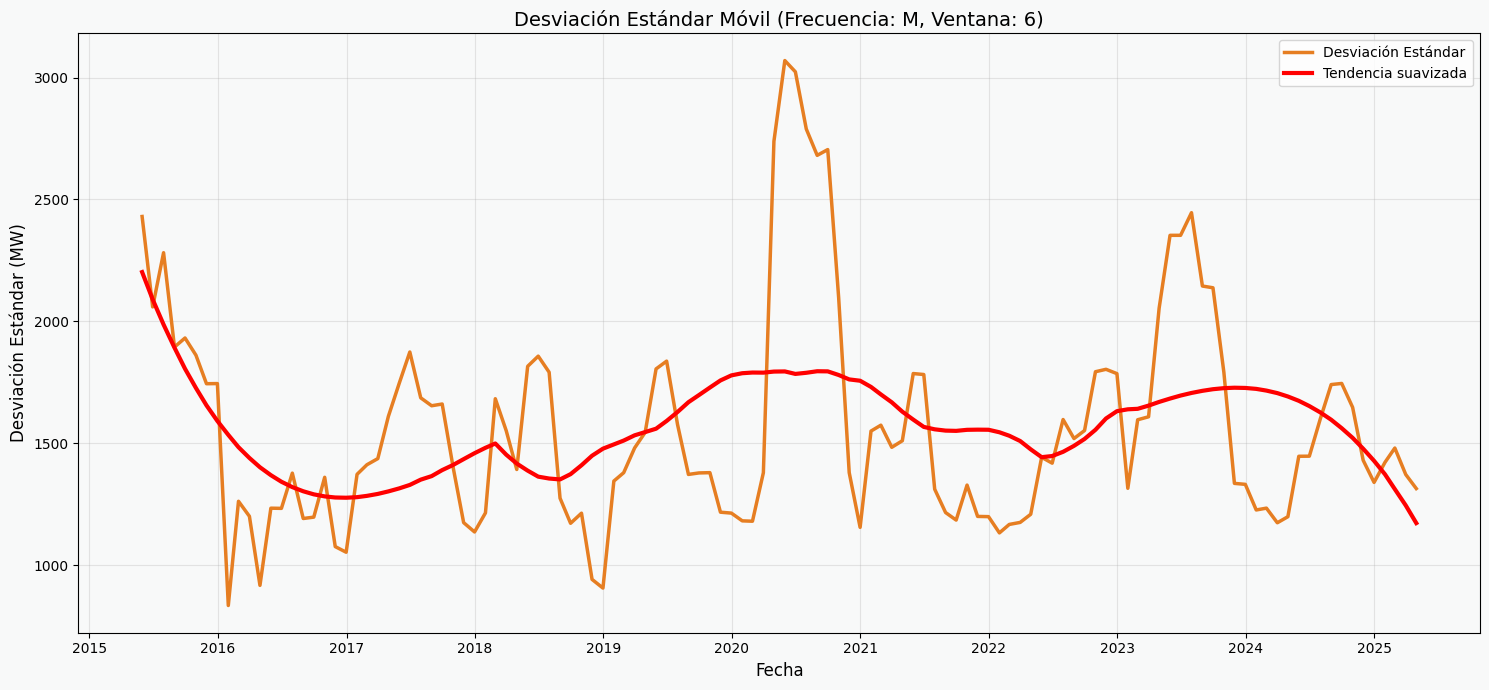

Resultados de la Prueba Dickey-Fuller Aumentada:
Estad√≠stico ADF: -6.716239858382118
p-value: 3.576093609027451e-09
# de Lags: 30
# de Observaciones: 3725
Conclusi√≥n: La serie es estacionaria (rechazamos la hip√≥tesis nula)

=== AN√ÅLISIS COMPLETO FINALIZADO ===


In [ ]:


def cargar_datos(ruta_archivo):
    try:
        df = pd.read_excel(ruta_archivo)
        print(f"Archivo cargado correctamente: {df.shape[0]} filas, {df.shape[1]} columnas")
        return df
    except FileNotFoundError:
        print(f"¬°Error! No se encontr√≥ el archivo: {ruta_archivo}")
        print("Revisa la ruta del archivo y aseg√∫rate de que est√° en el directorio correcto.")
        print("Creando datos simulados para demostraci√≥n...")

        fechas = pd.date_range(start='2015-01-01', end='2025-03-25 20:20:00', freq='10T')

        np.random.seed(42)
        n = len(fechas)
        base = 25000

        hora_dia = np.sin(2 * np.pi * fechas.hour / 24) * 5000
        dia_semana = -np.sin(2 * np.pi * fechas.dayofweek / 7) * 2000
        mes_anual = np.sin(2 * np.pi * fechas.month / 12) * 3000


        tendencia = np.linspace(0, 5000, n) * (np.sin(np.linspace(0, 8*np.pi, n)) * 0.1 + 0.9)


        ruido = np.random.normal(0, 1000, n)


        demanda = base + hora_dia + dia_semana + mes_anual + tendencia + ruido

        df_simulado = pd.DataFrame({
            'datetime_utc': fechas,
            'value': demanda,
            'geo_id': [8741] * n,
            'geo_name': ['Peninsula'] * n
        })

        return df_simulado

def preparar_datos(df):
    df['datetime_utc'] = pd.to_datetime(df['datetime_utc'])
    df['datetime_utc'] = df['datetime_utc'].dt.tz_localize(None)

    df = df.set_index('datetime_utc')

    if 'geo_id' in df.columns and 'geo_name' in df.columns:
        df = df.drop(columns=['geo_id', 'geo_name'])

    if 'value' in df.columns:
        df = df.rename(columns={'value': 'demanda_mw'})

    df_hora = df['demanda_mw'].resample('H').mean().to_frame()
    df_dia = df['demanda_mw'].resample('D').mean().to_frame()

    print(f"Datos originales: {df.shape[0]} registros")
    print(f"Datos horarios: {df_hora.shape[0]} registros")
    print(f"Datos diarios: {df_dia.shape[0]} registros")

    return df, df_hora, df_dia

def crear_caracteristicas_tiempo(df):
    df['hora'] = df.index.hour
    df['dia_semana'] = df.index.dayofweek
    df['dia_mes'] = df.index.day
    df['mes'] = df.index.month
    df['a√±o'] = df.index.year
    df['es_finde'] = df['dia_semana'].isin([5, 6]).astype(int)
    return df

def analizar_patrones(df):
    plt.figure(figsize=(15, 7))
    sns.boxplot(x='hora', y='demanda_mw', data=df.reset_index())
    plt.title('Patr√≥n Diario de Demanda El√©ctrica', fontsize=16)
    plt.xlabel('Hora del d√≠a', fontsize=14)
    plt.ylabel('Demanda (MW)', fontsize=14)
    plt.grid(True, axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(15, 7))
    sns.boxplot(x='dia_semana', y='demanda_mw', data=df.reset_index())
    plt.title('Patr√≥n Semanal de Demanda El√©ctrica', fontsize=16)
    plt.xlabel('D√≠a de la semana (0=Lunes, 6=Domingo)', fontsize=14)
    plt.ylabel('Demanda (MW)', fontsize=14)
    plt.grid(True, axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(15, 7))
    sns.boxplot(x='mes', y='demanda_mw', data=df.reset_index())
    plt.title('Patr√≥n Mensual de Demanda El√©ctrica', fontsize=16)
    plt.xlabel('Mes', fontsize=14)
    plt.ylabel('Demanda (MW)', fontsize=14)
    plt.grid(True, axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()

def descomponer_series(df_hora, df):
    print("Realizando descomposici√≥n estacional diaria...")
    descomposicion = seasonal_decompose(df_hora['demanda_mw'], model='additive', period=24)

    plt.figure(figsize=(15, 15))
    plt.subplot(411)
    plt.plot(descomposicion.observed)
    plt.title('Observado', fontsize=14)
    plt.grid(True, alpha=0.3)

    plt.subplot(412)
    plt.plot(descomposicion.trend)
    plt.title('Tendencia', fontsize=14)
    plt.grid(True, alpha=0.3)

    plt.subplot(413)
    plt.plot(descomposicion.seasonal)
    plt.title('Estacionalidad', fontsize=14)
    plt.grid(True, alpha=0.3)

    plt.subplot(414)
    plt.plot(descomposicion.resid)
    plt.title('Residuos', fontsize=14)
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    print("\nRealizando descomposici√≥n estacional semanal...")
    try:
        if len(df) > 50000:
            muestra = df.iloc[-50000:].copy()
            print(f"Usando muestra de {len(muestra)} registros para descomposici√≥n semanal")
            descomposicion_semanal = seasonal_decompose(muestra['demanda_mw'], model='additive', period=1008)
        else:
            descomposicion_semanal = seasonal_decompose(df['demanda_mw'], model='additive', period=1008)

        plt.figure(figsize=(15, 15))
        plt.subplot(411)
        plt.plot(descomposicion_semanal.observed)
        plt.title('Observado - Patr√≥n Semanal', fontsize=14)
        plt.grid(True, alpha=0.3)

        plt.subplot(412)
        plt.plot(descomposicion_semanal.trend)
        plt.title('Tendencia - Patr√≥n Semanal', fontsize=14)
        plt.grid(True, alpha=0.3)

        plt.subplot(413)
        plt.plot(descomposicion_semanal.seasonal)
        plt.title('Estacionalidad - Patr√≥n Semanal', fontsize=14)
        plt.grid(True, alpha=0.3)

        plt.subplot(414)
        plt.plot(descomposicion_semanal.resid)
        plt.title('Residuos - Patr√≥n Semanal', fontsize=14)
        plt.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Error en descomposici√≥n semanal: {e}")
        print("Intenta con una muestra m√°s peque√±a o ajusta el par√°metro de periodo.")

def analizar_correlacion(df_hora):
    print("\nAnalizando funciones de autocorrelaci√≥n...")
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))
    plot_acf(df_hora['demanda_mw'], lags=72, ax=ax1)
    ax1.set_title('Funci√≥n de Autocorrelaci√≥n (ACF)', fontsize=14)
    plot_pacf(df_hora['demanda_mw'], lags=72, ax=ax2)
    ax2.set_title('Funci√≥n de Autocorrelaci√≥n Parcial (PACF)', fontsize=14)
    plt.tight_layout()
    plt.show()

def desviacion_estandar_suavizada(df_original, frecuencia='W', ventana=12):

    print(f"\nCalculando desviaci√≥n est√°ndar m√≥vil con agregaci√≥n {frecuencia}...")
    df_resampled = df_original['demanda_mw'].resample(frecuencia).mean()

    std_movil = df_resampled.rolling(window=ventana).std()


    plt.figure(figsize=(15, 7))
    plt.title(f'Desviaci√≥n Est√°ndar M√≥vil (Frecuencia: {frecuencia}, Ventana: {ventana})', fontsize=14)
    plt.plot(std_movil, label=f'Desviaci√≥n Est√°ndar',
             linewidth=2.5, color='#E67E22')


    if len(std_movil) > 50:
        try:
            std_smooth = savgol_filter(std_movil.dropna(),
                                      min(51, len(std_movil.dropna()) - (len(std_movil.dropna()) % 2 + 1)),
                                      3)
            plt.plot(std_movil.dropna().index, std_smooth, 'r-',
                    linewidth=3, label='Tendencia suavizada')
        except Exception as e:
            print(f"No se pudo aplicar el filtro de suavizado: {e}")

    plt.xlabel('Fecha', fontsize=12)
    plt.ylabel('Desviaci√≥n Est√°ndar (MW)', fontsize=12)
    plt.legend(loc='upper right')
    plt.grid(True, alpha=0.3)
    plt.gcf().set_facecolor('#F8F9F9')
    plt.gca().set_facecolor('#F8F9F9')
    plt.tight_layout()
    plt.show()

    return std_movil

def test_estacionariedad(serie, window=12):
    print("\nRealizando test de estacionariedad...")
    media_movil = serie.rolling(window=window).mean()
    std_movil = serie.rolling(window=window).std()

    plt.figure(figsize=(15, 7))
    plt.title(f'Estad√≠sticas M√≥viles (Ventana de {window} periodos)', fontsize=14)
    plt.plot(serie, label='Original', alpha=0.7)
    plt.plot(media_movil, label='Media M√≥vil', linewidth=1.5)
    plt.plot(std_movil, label='Desviaci√≥n Est√°ndar M√≥vil', linewidth=1.5, color='orange')
    plt.legend(loc='best')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    std_diaria = desviacion_estandar_suavizada(serie.to_frame(), frecuencia='D', ventana=30)
    std_semanal = desviacion_estandar_suavizada(serie.to_frame(), frecuencia='W', ventana=12)
    std_mensual = desviacion_estandar_suavizada(serie.to_frame(), frecuencia='M', ventana=6)

    print('Resultados de la Prueba Dickey-Fuller Aumentada:')
    resultado = adfuller(serie.dropna())
    etiquetas = ['Estad√≠stico ADF', 'p-value', '# de Lags', '# de Observaciones']

    for etiqueta, valor in zip(etiquetas, resultado[:4]):
        print(f'{etiqueta}: {valor}')

    if resultado[1] <= 0.05:
        print("Conclusi√≥n: La serie es estacionaria (rechazamos la hip√≥tesis nula)")
    else:
        print("Conclusi√≥n: La serie no es estacionaria (no rechazamos la hip√≥tesis nula)")

def main():
    print("=== AN√ÅLISIS COMPLETO DE DEMANDA EL√âCTRICA ===\n")

    archivo = 'Unificado_def_2015_2025.xlsx'
    df_raw = cargar_datos(archivo)

    df, df_hora, df_dia = preparar_datos(df_raw)

    df = crear_caracteristicas_tiempo(df)

    print("\nAnalizando patrones temporales...")
    analizar_patrones(df)

    descomponer_series(df_hora, df)

    analizar_correlacion(df_hora)

    test_estacionariedad(df_dia['demanda_mw'], window=12)

    print("\n=== AN√ÅLISIS COMPLETO FINALIZADO ===")

    return df, df_hora, df_dia


if __name__ == "__main__":
    df, df_hora, df_dia = main()



==== Test de Dickey-Fuller para serie diaria ====
                   M√©trica         Valor
0          Estad√≠stico ADF      -6.71624
1                  p-valor  0.0000000036
2           N√∫mero de lags          30.0
3  N√∫mero de observaciones        3725.0
4       Valor cr√≠tico (1%)     -3.432107
5       Valor cr√≠tico (5%)     -2.862316
6      Valor cr√≠tico (10%)     -2.567183

Conclusi√≥n:
‚úÖ La serie ES ESTACIONARIA (rechazamos H‚ÇÄ)


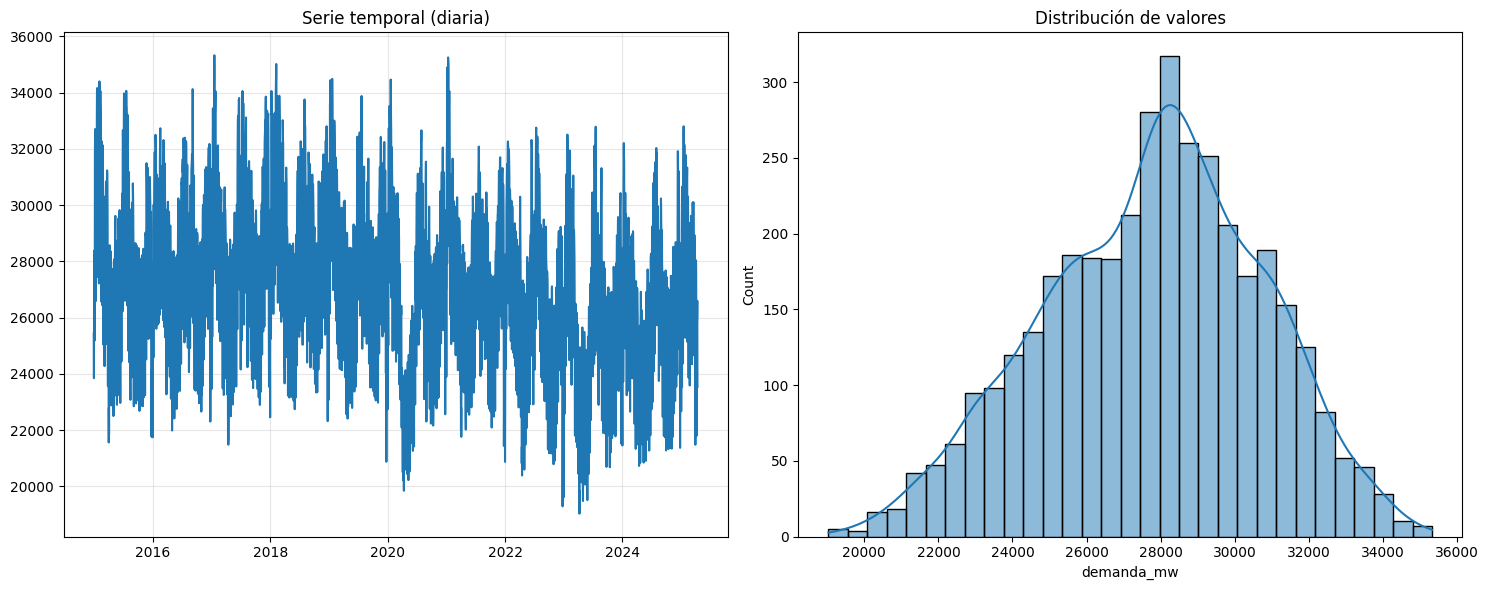


==== Test de Dickey-Fuller para serie semanal ====
                   M√©trica         Valor
0          Estad√≠stico ADF     -2.568595
1                  p-valor  0.0996634000
2           N√∫mero de lags          19.0
3  N√∫mero de observaciones         517.0
4       Valor cr√≠tico (1%)     -3.443062
5       Valor cr√≠tico (5%)     -2.867147
6      Valor cr√≠tico (10%)     -2.569756

Conclusi√≥n:
‚ùå La serie NO ES ESTACIONARIA (no rechazamos H‚ÇÄ)


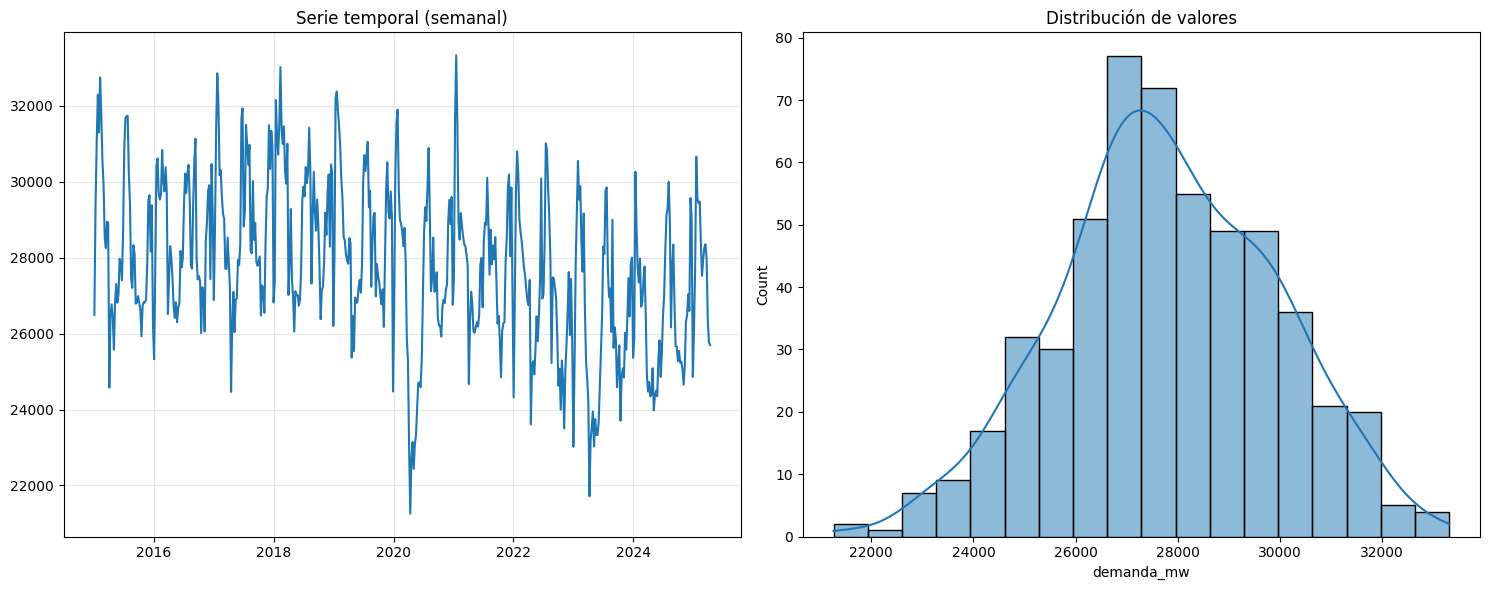


==== An√°lisis con diferenciaci√≥n (para remover tendencia) ====

==== Test de Dickey-Fuller para serie diaria diferenciada ====
                   M√©trica         Valor
0          Estad√≠stico ADF    -14.381854
1                  p-valor  0.0000000000
2           N√∫mero de lags          27.0
3  N√∫mero de observaciones        3727.0
4       Valor cr√≠tico (1%)     -3.432106
5       Valor cr√≠tico (5%)     -2.862316
6      Valor cr√≠tico (10%)     -2.567183

Conclusi√≥n:
‚úÖ La serie ES ESTACIONARIA (rechazamos H‚ÇÄ)


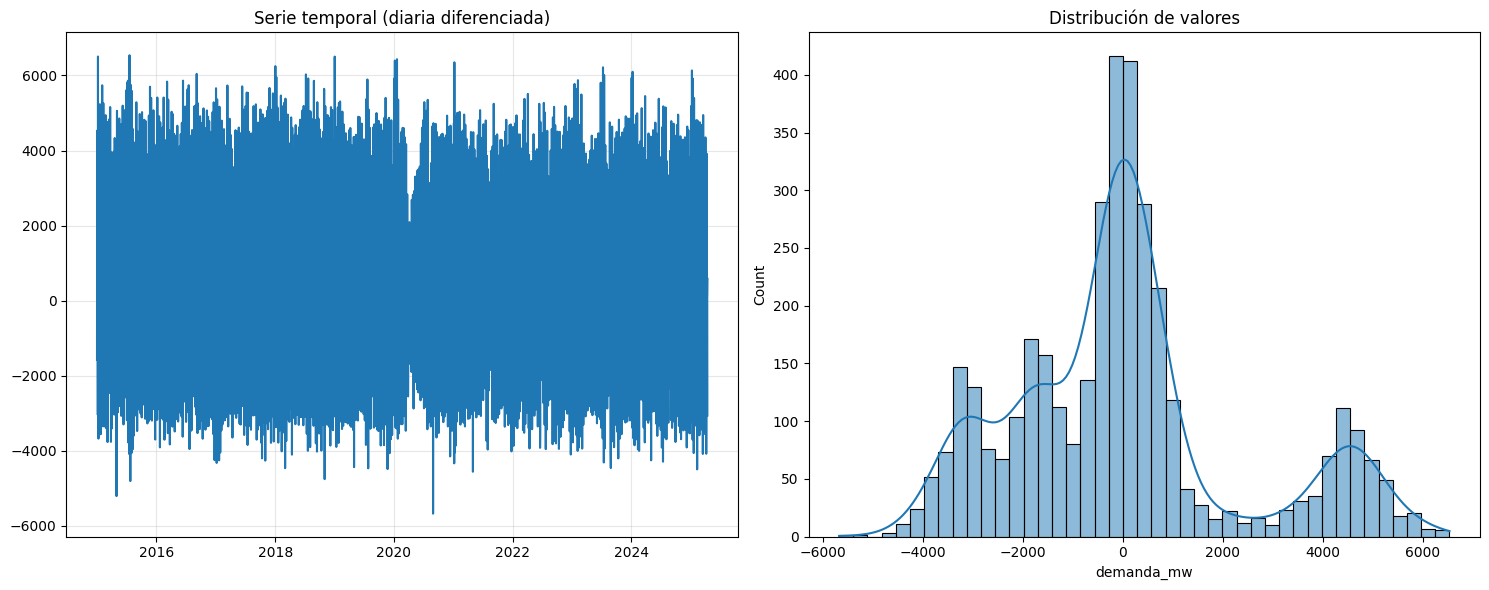

In [ ]:

df_hora = df['demanda_mw'].resample('H').mean()
df_dia = df['demanda_mw'].resample('D').mean()
df_semana = df['demanda_mw'].resample('W').mean()

def realizar_test_adf(serie, nombre):
    """Realiza el test de Dickey-Fuller y muestra resultados detallados"""
    print(f"\n==== Test de Dickey-Fuller para serie {nombre} ====")

    resultado = adfuller(serie.dropna())

    tabla = pd.DataFrame({
        'M√©trica': ['Estad√≠stico ADF', 'p-valor', 'N√∫mero de lags', 'N√∫mero de observaciones',
                    'Valor cr√≠tico (1%)', 'Valor cr√≠tico (5%)', 'Valor cr√≠tico (10%)'],
        'Valor': [resultado[0], resultado[1], resultado[2], resultado[3]] +
                 list(resultado[4].values())
    })

    tabla.loc[1, 'Valor'] = f"{tabla.loc[1, 'Valor']:.10f}"

    print(tabla)

    es_estacionaria = resultado[1] < 0.05
    print("\nConclusi√≥n:")
    if es_estacionaria:
        print("‚úÖ La serie ES ESTACIONARIA (rechazamos H‚ÇÄ)")
    else:
        print("‚ùå La serie NO ES ESTACIONARIA (no rechazamos H‚ÇÄ)")

    plt.figure(figsize=(15, 6))
    plt.subplot(1, 2, 1)
    plt.plot(serie)
    plt.title(f'Serie temporal ({nombre})')
    plt.grid(True, alpha=0.3)

    plt.subplot(1, 2, 2)
    sns.histplot(serie, kde=True)
    plt.title('Distribuci√≥n de valores')
    plt.tight_layout()
    plt.show()

    return resultado, es_estacionaria

resultado_dia, es_estacionaria_dia = realizar_test_adf(df_dia, "diaria")
resultado_semana, es_estacionaria_semana = realizar_test_adf(df_semana, "semanal")

print("\n==== An√°lisis con diferenciaci√≥n (para remover tendencia) ====")
df_dia_diff = df_dia.diff().dropna()
resultado_dia_diff, _ = realizar_test_adf(df_dia_diff, "diaria diferenciada")
